# Summary:
This notebook will cover performing **Latent Semantic Analysis (LSA)** using package from sklearn to embed abstract/bodytext with title/abstract/bodytext from the same paper as validation.

# Table of contents
* [1. preprocess text file](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 method1 -- WordNetLemmatizer](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 method2 -- ScispaCy](#Part1.2_link)
* [2. Tfidf and SVD](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Abstract + preprocess method1](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.1 num_topics=10](#Part2.1.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.2 num_topics=20](#Part2.1.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.3 num_topics=30](#Part2.1.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.4 num_topics=40](#Part2.1.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.5 num_topics=50](#Part2.1.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.6 num_topics=100](#Part2.1.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Body_text + preprocess method1](#Part2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 num_topics=10](#Part2.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 num_topics=20](#Part2.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3 num_topics=30](#Part2.2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.4 num_topics=40](#Part2.2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.5 num_topics=50](#Part2.2.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.6 num_topics=100](#Part2.2.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.3 Abstract + preprocess method2 (spaCy)](#Part2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 num_topics=10](#Part2.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 num_topics=20](#Part2.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 num_topics=30](#Part2.3.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.4 num_topics=40](#Part2.3.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.5 num_topics=50](#Part2.3.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.6 num_topics=100](#Part2.3.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.4 Body_text + preprocess method2 (spaCy)](#Part2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1 num_topics=10](#Part2.4.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.2 num_topics=20](#Part2.4.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.3 num_topics=30](#Part2.4.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.4 num_topics=40](#Part2.4.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.5 num_topics=50](#Part2.4.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.6 num_topics=100](#Part2.4.6_link)
* [3. Evaluate LSA models](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Distribution of number of papers in each topic](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Evaluate the topic prediction performance of LSA models](#Part3.2_link)
<br >&nbsp;&nbsp;&nbsp;[3.3 Compute cosine similarity for titles, abstracts and bodytext of each paper](#Part3.3_link)
<br >&nbsp;&nbsp;&nbsp;[3.4 Evaluate cosine similarity](#Part3.4_link)
* [4. Compare LSA models using Gensim and Sklearn](#Part4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import json
import glob
from ast import literal_eval
from tqdm import tqdm

import gensim
import nltk
from nltk.stem import WordNetLemmatizer

import spacy
import scispacy
import en_core_sci_lg

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import cohen_kappa_score
import joblib
import glob
import pickle

In [2]:
base_dir="/Volumes/Yuchen_Drive/COVID19/CORD19"

In [4]:
data_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_21423_text_all_df.csv"),index_col="paper_id",
                    dtype={"pubmed_id":str},
                    converters={"title2":literal_eval,"abstract2":literal_eval,"body_text2":literal_eval,
                                "title3":literal_eval,"abstract3":literal_eval,"body_text3":literal_eval},
                    parse_dates=["publish_time"])

In [5]:
print(data_df.shape)
data_df.head()

(21423, 19)


,title,abstract,body_text,pubmed_id,publish_time,journal,abstract2,body_text2,title2,abstract3,body_text3,title3,abstract2_wordcount,bodytext2_wordcount,title2_wordcount,abstract3_wordcount,bodytext3_wordcount,title3_wordcount,bow_corpus
paper_id,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,immunity to pathogens taught by specialized hu...,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,26528289,2015-10-13,Front Immunol,"[dendritic, dc, specialized, antigen, presenti...","[introduction, constantly, exposed, myriad, pa...","[immunity, pathogen, taught, specialized, dend...","[dendritic, dcs, specialize, antigen-presentin...","[introduction, constantly, expose, myriad, pat...","[immunity, pathogen, teach, specialize, dendri...",147,2328,6,147,2256,6,"[(0, 1), (1, 2), (2, 2), (3, 1), (4, 2), (5, 1..."
0022796bb2112abd2e6423ba2d57751db06049fb,Public Health Responses to and Challenges for ...,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,27643596,2016-09-19,PLoS Negl Trop Dis,"[dengue, negative, impact, lower, middle, inco...","[pathogen, vector, transported, rapidly, world...","[public, health, challenge, dengue, transmissi...","[dengue, negative, impact, low-and, middle-inc...","[pathogens, vector, transport, rapidly, world,...","[public, health, responses, challenges, dengue...",148,3549,7,140,3431,9,"[(2, 1), (3, 2), (5, 2), (9, 5), (16, 1), (19,..."
0031e47b76374e05a18c266bd1a1140e5eacb54f,The fecal microbiota of healthy donor horses a...,"Fecal microbial transplantation (FMT), a treat...",a1111111111 a1111111111 a1111111111 a111111111...,32155205,2020-03-10,PLoS One,"[fecal, microbial, transplantation, fmt, treat...","[intestinal, microbiome, imbalance, dysbiosis,...","[fecal, microbiota, healthy, donor, horse, ger...","[fecal, microbial, transplantation, fmt, treat...","[a1111111111, a1111111111, a1111111111, a11111...","[fecal, microbiota, healthy, donor, horse, ger...",73,2361,13,71,2294,13,"[(3, 3), (4, 1), (5, 2), (9, 1), (10, 1), (21,..."
00326efcca0852dc6e39dc6b7786267e1bc4f194,a section of the journal Frontiers in Pediatri...,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...,26925393,2016-02-18,Front Pediatr,"[year, ago, united, nation, world, leader, def...","[preventative, care, nutritional, support, dev...","[section, journal, frontier, pediatrics, revie...","[year, ago, united, nations, world, leader, de...","[preventative, care, nutritional, support, dev...","[section, journal, frontiers, pediatrics, revi...",90,4021,15,87,3842,14,"[(1, 1), (3, 1), (5, 2), (9, 1), (19, 6), (21,..."
00352a58c8766861effed18a4b079d1683fec2ec,MINI REVIEW Function of the Deubiquitinating E...,Posttranslational modification of proteins by ...,Ubiquitination is a widely used posttranslatio...,29302259,2017-12-14,Front Synaptic Neurosci,"[modification, ubiquitin, regulates, synapse, ...","[ubiquitination, widely, modification, emerged...","[mini, review, function, enzyme, usp, nervous,...","[posttranslational, modification, ubiquitin, r...","[ubiquitination, widely, posttranslational, mo...","[mini, review, function, deubiquitinating, enz...",72,1538,9,69,1485,10,"[(1, 1), (6, 5), (10, 2), (11, 1), (14, 1), (1..."


<a id='Part1_link'></a>
## 1. preprocess text file
**Note**: For sklearn, text preprocessing can be performed during building count matrix.

In [24]:
abstract2_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract2_TF_pre_df.csv"),index_col="token_id")
abstract2_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract2_DF_df.csv"),index_col="token_id")
abstract3_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract3_TF_pre_df.csv"),index_col="token_id")
abstract3_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract3_DF_df.csv"),index_col="token_id")

bodytext2_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext2_TF_pre_df.csv"),index_col="token_id")
bodytext2_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext2_DF_df.csv"),index_col="token_id")
bodytext3_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext3_TF_pre_df.csv"),index_col="token_id")
bodytext3_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext3_DF_df.csv"),index_col="token_id")

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
list0 = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 
    'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', '-PRON-'
]

In [26]:
list1=list(abstract2_TF_pre.loc[abstract2_TF_pre.counts>10000].word.values)
list2=list(abstract2_DF.loc[abstract2_DF.counts>6000].word.values)
list3=list(abstract3_TF_pre.loc[abstract3_TF_pre.counts>9000].word.values)
list4=list(abstract3_DF.loc[abstract3_DF.counts>5000].word.values)
list5=list(bodytext2_TF_pre.loc[bodytext2_TF_pre.counts>100000].word.values)
list6=list(bodytext2_DF.loc[bodytext2_DF.counts>15000].word.values)
list7=list(bodytext3_TF_pre.word.values[:20])
list8=list(bodytext3_DF.loc[bodytext3_DF.counts>15000].word.values)
custom_words=set(list0+list1+list2+list3+list4+list5+list6+list7+list8)
print("Number of custom words: {}".format(len(custom_words)))

Number of custom words: 104


In [27]:
custom_words=[i.lower() for i in custom_words]

<a id='Part1.1_link'></a>
### 1.1 method1 -- WordNetLemmatizer

In [28]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
#stop_words = set(list(stop_word1)+stop_word2+list(punctuation))   ## 390+32=422
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
stop_words = set(list(stop_word1)+stop_word2+list(punct)+list(custom_words))
print(len(stop_words))

546


In [29]:
print(len(stop_words))

546


In [30]:
pickle.dump(stop_words,open(os.path.join(base_dir,"stop_words.pkl"),"wb"))

In [21]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return result

<a id='Part1.2_link'></a>
### 1.2 method2 -- ScispaCy

In [22]:
nlp = spacy.load("en_core_sci_lg",disable=["tagger","parser","ner"])

In [23]:
nlp.max_length=2000000

In [24]:
for token in custom_words:
    nlp.vocab[token].is_stop=True

In [25]:
def spacy_tokenizer(text):
    words=[token.lemma_.lower() for token in nlp(text) if not (token.like_num or token.is_stop or token.is_punct or token.is_space or len(token)==1)]
    return [token for token in words if token not in stop_words]

<a id='Part2_link'></a>
## 2. Tfidf and SVD

In [26]:
def print_top_words_lsa_sklearn(lsavector_df,vectorizer,vectorizer_matrix,n_top_words,print_message=True):
    feature_names=vectorizer.get_feature_names()
    topics_dict={}
    for i in range(num_topics):
        message="Topic"+str(i)+": "
        mask=(lsavector_df.pred==i).values
        subset_array=vectorizer_matrix[mask,:].toarray()
        term_sum=subset_array.sum(axis=0)
        indices=term_sum.argsort()[-n_top_words:][::-1]
        words=[feature_names[j] for j in indices]
        message+=" ".join(words)
        topics_dict["topic"+str(i)]=words
        if print_message:
            print(message)
    output=pd.DataFrame.from_dict(topics_dict)
    return output

In [27]:
def lsa_query_sklearn(text,vec,svd,num_topics):
    text_matrix=vec.transform(text)
    pred_matrix=svd.transform(text_matrix)
    pred_df=pd.DataFrame(pred_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
    return pred_df

In [28]:
def pred_rank(lsavector_df,pred_df,num_topics):
    pred_df["pred"]=lsavector_df.pred
    pred_df["rank"]=pred_df.apply(lambda x:num_topics-np.argwhere(x.values[:num_topics].argsort()==x.pred)[0][0],axis=1)
    return pred_df

<a id='Part2.1_link'></a>
### 2.1 Abstract + preprocess method1

In [337]:
tfidfvec=TfidfVectorizer(tokenizer=preprocess,min_df=2)
tfidfvec_matrix=tfidfvec.fit_transform(data_df.abstract)
print(tfidfvec_matrix.shape)

(21423, 29676)


In [338]:
countvec=CountVectorizer(tokenizer=preprocess,min_df=2)
countvec_matrix=countvec.fit_transform(data_df.abstract)
print(countvec_matrix.shape)

(21423, 29676)


In [339]:
joblib.dump(tfidfvec,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_tfidfvec.joblib"))
joblib.dump(countvec,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_countvec.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_countvec.joblib']

In [33]:
term_frequency=pd.DataFrame({"token":countvec.get_feature_names(),"counts":np.asarray(countvec_matrix.sum(axis=0)).squeeze()})
term_frequency.sort_values(by=["counts"],ascending=False,inplace=True)
term_frequency.head()

,token,counts
13301,influenza,8297
11562,health,7619
28375,vaccine,7372
5796,cov,7046
23851,sars,7041


In [34]:
term_frequency.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/word_counts/COVD19_meta_21423_text_df_abstract2_countvec_df.csv"),index=True)


In [35]:
tfidf_frequency=pd.DataFrame({"token":tfidfvec.get_feature_names(),"counts":np.asarray(tfidfvec_matrix.sum(axis=0)).squeeze()})
tfidf_frequency.sort_values(by=["counts"],ascending=False,inplace=True)
tfidf_frequency.head()

,token,counts
13301,influenza,343.514121
23851,sars,341.012147
5796,cov,320.352770
28375,vaccine,292.630891
11562,health,274.298852


In [42]:
#tfidfvec_matrix.toarray().sum(axis=0)

array([25.0538132 ,  0.93294018,  1.14955336, ...,  0.26199324,
        0.14841825,  0.10558449])

In [36]:
tfidf_frequency.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/word_counts/COVD19_meta_21423_text_df_abstract2_tfidfvec_df.csv"),index=True)


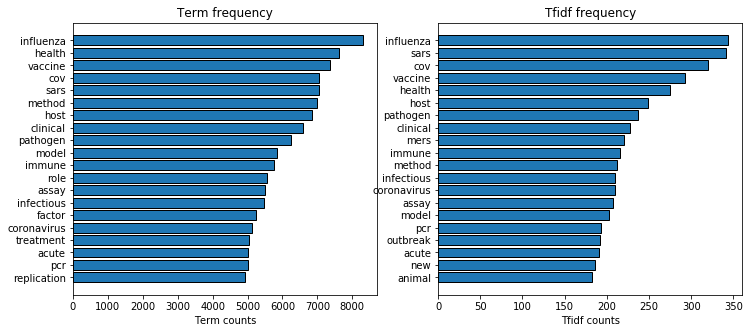

In [37]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
axes[0].barh(term_frequency.token.values[:20],term_frequency.counts.values[:20],edgecolor="black")
axes[0].set_title("Term frequency")
axes[0].set_xlabel("Term counts")
axes[0].invert_yaxis()
axes[1].barh(tfidf_frequency.token.values[:20],tfidf_frequency.counts.values[:20],edgecolor="black")
axes[1].set_title("Tfidf frequency")
axes[1].set_xlabel("Tfidf counts")
axes[1].invert_yaxis()

<a id='Part2.1.1_link'></a>
#### 2.1.1 num_topics=10

In [43]:
num_topics=10
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 11)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.138579,-0.056617,-0.162279,-0.034523,0.000596,-0.124106,0.080670,0.115989,-0.066291,0.062065,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.135886,-0.051863,0.057548,-0.115893,-0.011253,0.038038,-0.029816,0.011542,-0.032499,-0.003010,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.054405,-0.034597,0.015235,0.034342,-0.018316,0.015784,-0.015679,0.039645,-0.018252,0.020624,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.161594,-0.078671,0.128901,-0.110131,0.029218,0.011126,-0.031448,0.058190,-0.057905,-0.045433,0
00352a58c8766861effed18a4b079d1683fec2ec,0.063435,-0.017332,-0.061102,-0.023766,-0.001080,-0.023134,-0.036171,-0.005181,0.016657,-0.024144,0


In [45]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector10_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector10_df.csv"),index_col="paper_id")


In [46]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_lsa10.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21600_text_df_abstract2_lsa10.joblib']

In [47]:
topic_counts_df1=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df1.head()

,topic,counts
0,0,16643
1,3,858
2,1,769
3,7,643
4,6,580


In [49]:
print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10)

Topic0: health host pathogen infectious model immune clinical method replication new
Topic1: cov mers sars coronavirus syndrome middle east camel severe spike
Topic2: child influenza rsv hospital care pneumonia health year ci ili
Topic3: pcr assay child rt detection hbov rsv detected positive specimen
Topic4: sars acute syndrome severe outbreak hospital coronavirus worker health care
Topic5: pedv porcine diarrhea piglet epidemic pig pdcov ped swine orf
Topic6: vaccine influenza vaccination dna immune antigen adjuvant protection vector immunization
Topic7: ifn il cd calf cytokine macrophage inflammatory induced cns prrsv
Topic8: influenza pandemic ifitm avian ili pdm surveillance seasonal host na
Topic9: bat specie reservoir host coronaviruses covs cov phylogenetic zoonotic detected


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,health,cov,child,pcr,sars,pedv,vaccine,ifn,influenza,bat
1,host,mers,influenza,assay,acute,porcine,influenza,il,pandemic,specie
2,pathogen,sars,rsv,child,syndrome,diarrhea,vaccination,cd,ifitm,reservoir
3,infectious,coronavirus,hospital,rt,severe,piglet,dna,calf,avian,host
4,model,syndrome,care,detection,outbreak,epidemic,immune,cytokine,ili,coronaviruses
5,immune,middle,pneumonia,hbov,hospital,pig,antigen,macrophage,pdm,covs
6,clinical,east,health,rsv,coronavirus,pdcov,adjuvant,inflammatory,surveillance,cov
7,method,camel,year,detected,worker,ped,protection,induced,seasonal,phylogenetic
8,replication,severe,ci,positive,health,swine,vector,cns,host,zoonotic
9,new,spike,ili,specimen,care,orf,immunization,prrsv,na,detected


In [50]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9659711524996499


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.036882,-0.024761,-0.018960,-0.009349,-0.006055,-0.018642,0.010777,0.013673,-0.025780,0.028442,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.108236,-0.044325,0.113864,-0.206925,0.012515,0.093540,-0.068786,0.018940,-0.033738,-0.032126,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039316,-0.025462,-0.000639,0.029704,-0.023003,0.030207,-0.005376,0.055069,-0.017716,0.009154,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.056634,-0.028057,0.036548,-0.053378,0.013489,0.001994,-0.026945,0.016011,-0.022740,-0.024373,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.040451,-0.013383,-0.045169,-0.015296,0.006977,-0.023206,-0.023430,0.007708,0.003312,-0.024693,0,1


In [51]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index=True)

In [52]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.996078980534939


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.192220,-0.077207,-0.210385,-0.013261,0.002169,-0.168605,0.095685,0.153215,-0.067187,0.062711,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.195673,-0.082645,0.083650,-0.125446,0.008910,0.058342,-0.053839,0.030141,-0.028348,-0.022305,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.113701,-0.057355,0.018789,0.023306,-0.018777,0.015632,-0.028977,0.051384,-0.032874,0.014415,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271311,-0.124732,0.224525,-0.166889,0.073756,0.024655,-0.085898,0.115638,-0.081081,-0.095325,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.065000,-0.014970,-0.066129,-0.009416,0.001629,-0.021176,-0.032597,-0.011408,0.025208,-0.032642,0,1


In [53]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index=True)


<a id='Part2.1.2_link'></a>
#### 2.1.2 num_topics=20

In [54]:
num_topics=20
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 21)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.138579,-0.056516,-0.162036,-0.034709,-0.001314,-0.124494,0.084275,0.113573,-0.070250,0.062547,...,-0.005078,0.046943,-0.008971,0.168474,-0.053895,-0.095772,-0.098106,-0.026834,0.016965,14
0022796bb2112abd2e6423ba2d57751db06049fb,0.135886,-0.051743,0.057591,-0.116819,-0.011522,0.039630,-0.029858,0.009497,-0.034316,-0.000534,...,0.011752,0.017537,-0.017323,0.023147,0.021202,-0.018173,-0.014252,-0.037571,0.003695,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.054404,-0.034602,0.015188,0.034148,-0.018313,0.016154,-0.015167,0.039778,-0.018111,0.021153,...,0.000838,-0.036414,0.036146,-0.025602,-0.008142,-0.004297,0.001494,0.003836,0.020602,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.161594,-0.078666,0.128919,-0.109983,0.029296,0.010486,-0.031382,0.059060,-0.057302,-0.045929,...,-0.023153,0.034277,-0.028007,0.044194,0.027756,0.043864,0.041850,0.001750,0.011940,0
00352a58c8766861effed18a4b079d1683fec2ec,0.063435,-0.017384,-0.061068,-0.022977,-0.000738,-0.025303,-0.036255,-0.004251,0.017319,-0.025696,...,-0.018642,0.008635,0.000311,-0.027166,-0.010437,-0.008849,-0.005728,0.006669,0.018425,0


In [55]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector20_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector20_df.csv"),index_col="paper_id")

In [56]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_lsa20.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21600_text_df_abstract2_lsa20.joblib']

In [57]:
topic_counts_df2=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df2.head()

,topic,counts
0,0,14064
1,1,767
2,3,638
3,14,621
4,11,563


In [58]:
output=print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10)

Topic0: health host pathogen model infectious immune method clinical influenza review
Topic1: cov mers sars coronavirus syndrome middle east camel severe spike
Topic2: child influenza rsv hospital care year pneumonia ci health ili
Topic3: pcr child assay hbov rsv detection detected rt hmpv positive
Topic4: sars acute syndrome severe outbreak hospital coronavirus worker health care
Topic5: pedv porcine diarrhea piglet epidemic pig pdcov ped swine orf
Topic6: vaccine influenza vaccination dna immune antigen adjuvant protection vector immunization
Topic7: il ifn cytokine inflammatory macrophage induced lung cns tnf asthma
Topic8: influenza pandemic ifitm avian ili pdm surveillance seasonal host na
Topic9: bat specie reservoir host coronaviruses covs cov zoonotic sars diversity
Topic10: assay lamp rt pcr detection amplification rpa ifn sensitivity real
Topic11: cat feline ibv fip fcov fipv infectious peritonitis coronavirus bronchitis
Topic12: ibv chicken bronchitis infectious vaccine ifn 

In [59]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.8959529477664193


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.036881,-0.024784,-0.018967,-0.008797,-0.005639,-0.019446,0.010054,0.013741,-0.026258,0.027531,...,0.009250,0.002060,-0.013761,-0.010910,-0.037056,-0.039646,0.015187,-0.035086,14,12
0022796bb2112abd2e6423ba2d57751db06049fb,0.108236,-0.044207,0.113915,-0.208308,0.011799,0.095895,-0.068012,0.020202,-0.037989,-0.029371,...,0.063962,-0.021158,0.103938,0.089378,0.038663,-0.057503,0.069576,0.025173,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039316,-0.025457,-0.000696,0.029311,-0.023022,0.030698,-0.004500,0.054541,-0.017174,0.010164,...,-0.050604,0.050211,-0.031207,-0.010633,0.018306,0.001831,0.007230,0.022069,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.056634,-0.028078,0.036537,-0.053033,0.013795,0.000999,-0.027317,0.016781,-0.022066,-0.024509,...,0.010679,-0.005911,0.007296,-0.005838,0.007756,0.023011,-0.003058,-0.006027,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.040452,-0.013412,-0.045118,-0.014858,0.007027,-0.024491,-0.022992,0.008341,0.004094,-0.025493,...,-0.001197,0.009919,-0.006142,-0.022393,-0.006130,-0.009604,0.030066,0.018178,0,1


In [60]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index=True)

In [61]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9840358493208234


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.192221,-0.077076,-0.210073,-0.013860,-0.000744,-0.167819,0.101216,0.151899,-0.072267,0.063592,...,0.061865,-0.000495,0.222693,-0.052055,-0.080868,-0.094076,-0.046521,0.036169,14,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.195674,-0.082458,0.083787,-0.126994,0.008049,0.060805,-0.052403,0.027165,-0.030551,-0.018603,...,0.011732,-0.004363,0.041765,0.016464,-0.022217,-0.006018,-0.085098,-0.021614,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.113701,-0.057352,0.018764,0.022941,-0.018837,0.016202,-0.027853,0.051530,-0.032418,0.015493,...,-0.048567,0.046494,-0.026842,-0.016801,-0.002140,0.023747,-0.011012,0.018088,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271311,-0.124686,0.224721,-0.167428,0.072514,0.024249,-0.083363,0.118622,-0.080751,-0.093749,...,0.051176,-0.022962,0.109708,0.027094,0.063669,0.115962,-0.028273,-0.014699,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.065001,-0.014988,-0.066047,-0.009164,0.001255,-0.021904,-0.031313,-0.009974,0.024937,-0.032732,...,-0.001135,0.006427,0.011003,-0.002460,0.000271,-0.001040,0.003417,0.005625,0,1


In [62]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index=True)

<a id='Part2.1.3_link'></a>
#### 2.1.3 num_topics=30

In [63]:
num_topics=30
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 31)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.138579,-0.056526,-0.162086,-0.034768,-0.001103,-0.124366,0.083663,0.115090,-0.069647,0.061100,...,0.030391,-0.148906,-0.073746,-0.002579,0.048633,0.076839,-0.047390,0.072438,0.052452,14
0022796bb2112abd2e6423ba2d57751db06049fb,0.135886,-0.051774,0.057659,-0.117052,-0.011639,0.039008,-0.028516,0.009987,-0.032533,-0.000667,...,0.026158,0.027373,0.023457,0.055451,0.008452,-0.009630,0.045568,-0.111088,0.022672,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.054404,-0.034601,0.015187,0.034163,-0.018336,0.016211,-0.015395,0.039765,-0.018226,0.021628,...,-0.003462,-0.015582,-0.006598,-0.013289,-0.010711,0.022005,-0.004744,-0.002952,-0.009977,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.161594,-0.078659,0.128907,-0.109939,0.029451,0.010515,-0.031376,0.059101,-0.056300,-0.047237,...,-0.037178,-0.010129,-0.039042,0.005429,0.015090,-0.011015,-0.042506,0.030290,0.021978,0
00352a58c8766861effed18a4b079d1683fec2ec,0.063436,-0.017375,-0.061062,-0.022986,-0.000690,-0.025177,-0.036819,-0.004781,0.016982,-0.025794,...,0.033566,-0.009206,-0.028334,0.011244,0.028342,-0.001497,0.024673,0.015374,0.005672,0


In [64]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector30_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector30_df.csv"),index_col="paper_id")

In [65]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_lsa30.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21600_text_df_abstract2_lsa30.joblib']

In [66]:
topic_counts_df3=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df3.head()

,topic,counts
0,0,13134
1,1,764
2,11,540
3,6,522
4,14,507


In [67]:
output=print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10,print_message=False)
output.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic20,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29
0,health,cov,influenza,pcr,sars,pedv,vaccine,il,influenza,bat,...,cd,rsv,mhv,model,hcov,nsp,dog,asthma,tgev,hbov
1,host,mers,child,child,acute,porcine,influenza,ifn,pandemic,specie,...,prrsv,frameshifting,jhm,contact,ifitm,sars,canine,hrv,transmissible,hiv
2,pathogen,sars,hospital,assay,syndrome,diarrhea,vaccination,cytokine,avian,reservoir,...,lymphocyte,codon,hepatitis,network,hcv,replication,cpv,exacerbation,gastroenteritis,child
3,model,coronavirus,care,detection,severe,piglet,dna,inflammatory,ili,host,...,pig,usage,demyelination,epidemic,autophagy,mutant,ccov,rhinovirus,prcv,bocavirus
4,infectious,syndrome,rsv,rt,outbreak,epidemic,immune,macrophage,ifitm,coronaviruses,...,hiv,genome,cns,transmission,nl,coronavirus,parvovirus,airway,piglet,tract


In [68]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.85529571021799


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.036881,-0.024787,-0.018988,-0.008772,-0.005574,-0.019350,0.009612,0.013928,-0.025886,0.027562,...,-0.031625,0.007285,-0.028541,0.021046,0.018291,-0.021421,0.028453,0.019601,14,19
0022796bb2112abd2e6423ba2d57751db06049fb,0.108236,-0.044236,0.113965,-0.208479,0.011621,0.095296,-0.066858,0.020566,-0.036338,-0.028361,...,0.028891,0.002255,0.022619,-0.019593,0.010790,0.049466,-0.101357,0.040059,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039316,-0.025457,-0.000701,0.029334,-0.023046,0.030882,-0.004979,0.054751,-0.017318,0.010386,...,-0.003075,-0.013964,-0.015830,-0.011580,0.023913,-0.005446,0.004311,-0.019538,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.056634,-0.028070,0.036531,-0.053018,0.013929,0.001177,-0.027447,0.016833,-0.021705,-0.025475,...,-0.003728,-0.027365,-0.008030,0.012869,-0.009233,-0.027965,0.031197,-0.007341,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.040452,-0.013402,-0.045119,-0.014850,0.007091,-0.024303,-0.023496,0.008020,0.003773,-0.025479,...,0.000142,-0.013478,0.005105,0.029154,0.002564,0.010197,0.014234,0.006782,0,1


In [69]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index=True)

In [70]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9769873500443449


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.192221,-0.077083,-0.210094,-0.013926,-0.000460,-0.167934,0.100794,0.152743,-0.072146,0.062392,...,-0.164873,-0.085598,-0.002039,0.031665,0.070159,-0.068241,0.065882,0.030143,14,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.195674,-0.082498,0.083854,-0.127326,0.007807,0.060219,-0.051192,0.028174,-0.028314,-0.018433,...,0.039967,0.043340,0.086479,0.013116,-0.031254,0.065752,-0.129800,0.045808,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.113701,-0.057348,0.018764,0.022961,-0.018832,0.016330,-0.028194,0.051551,-0.032706,0.016050,...,-0.008161,-0.008024,-0.010990,-0.011122,0.018640,0.000636,0.005978,-0.018952,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271311,-0.124671,0.224692,-0.167370,0.072950,0.024444,-0.083493,0.118705,-0.079159,-0.095967,...,-0.018558,-0.097248,0.027313,0.022742,-0.034012,-0.078214,0.077487,0.022755,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.065001,-0.014978,-0.066022,-0.009189,0.001369,-0.021886,-0.031732,-0.010380,0.024747,-0.032764,...,-0.010926,-0.019363,0.005739,0.027525,-0.003245,0.034912,0.016244,-0.001961,0,1


In [71]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index=True)

<a id='Part2.1.4_link'></a>
#### 2.1.4 num_topics=40

In [72]:
num_topics=40
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 41)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.138579,-0.056540,-0.162085,-0.034728,-0.001076,-0.124443,0.083894,0.114604,-0.069951,0.061028,...,-0.001231,0.048008,-0.016635,-0.058710,-0.074535,0.041086,0.011501,0.057247,0.003324,14
0022796bb2112abd2e6423ba2d57751db06049fb,0.135886,-0.051774,0.057666,-0.117089,-0.011783,0.038831,-0.028846,0.009540,-0.033336,-0.000468,...,0.133809,0.006945,0.075074,0.003882,-0.001600,-0.072564,0.038611,-0.012229,0.034991,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.054404,-0.034601,0.015187,0.034165,-0.018324,0.016232,-0.015356,0.039692,-0.018194,0.021459,...,-0.006663,-0.003721,0.008689,0.014147,-0.003132,0.013096,-0.011938,-0.003333,0.017053,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.161594,-0.078662,0.128892,-0.109987,0.029407,0.010551,-0.031514,0.058941,-0.056781,-0.046666,...,0.002760,-0.028655,-0.056837,-0.016316,0.015679,0.065010,0.033723,0.010603,-0.021306,0
00352a58c8766861effed18a4b079d1683fec2ec,0.063436,-0.017374,-0.061065,-0.023005,-0.000782,-0.025307,-0.036990,-0.004771,0.016948,-0.025904,...,-0.008377,-0.012618,-0.025034,-0.025843,-0.016894,-0.016420,0.025525,-0.017018,-0.021517,0


In [73]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector40_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector30_df.csv"),index_col="paper_id")

In [74]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_lsa40.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21600_text_df_abstract2_lsa40.joblib']

In [75]:
topic_counts_df4=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df4.head()

,topic,counts
0,0,12571
1,1,764
2,11,532
3,6,514
4,14,471


In [76]:
output=print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10,print_message=False)
output.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic30,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39
0,health,cov,child,pcr,sars,pedv,vaccine,ifn,influenza,bat,...,hbov,zikv,tgev,autophagy,sirna,hiv,hrv,hcv,codon,cns
1,host,mers,influenza,child,acute,porcine,influenza,il,pandemic,specie,...,child,denv,il,hcv,rnai,ifitm,ppe,hepatitis,usage,nervous
2,pathogen,sars,hospital,assay,syndrome,diarrhea,vaccination,cytokine,avian,reservoir,...,bocavirus,dengue,pneumonia,atg,membrane,il,gp,liver,hbov,demyelination
3,model,coronavirus,care,detection,severe,piglet,dna,macrophage,ili,host,...,tract,zika,hiv,serum,golgi,ifitms,ev,chronic,zika,central
4,infectious,syndrome,rsv,rt,outbreak,epidemic,immune,inflammatory,surveillance,coronaviruses,...,detected,flavivirus,cap,replication,image,cytokine,ebov,genotype,ttsuv,immune


In [77]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.8124912477244084


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.036881,-0.024786,-0.018976,-0.008760,-0.005508,-0.019334,0.009833,0.013943,-0.026022,0.027291,...,0.010523,0.007407,-0.054857,0.005013,-0.000343,-0.002133,-0.004221,0.006057,14,27
0022796bb2112abd2e6423ba2d57751db06049fb,0.108236,-0.044232,0.113993,-0.208481,0.011609,0.095251,-0.067086,0.020339,-0.036930,-0.028575,...,0.006501,0.072641,0.001815,-0.011579,-0.082059,-0.019337,-0.034087,0.041786,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039316,-0.025457,-0.000702,0.029349,-0.023033,0.030933,-0.004871,0.054643,-0.017255,0.010181,...,-0.004940,-0.010537,0.027877,-0.008777,0.018506,0.005452,0.007097,0.004219,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.056634,-0.028073,0.036519,-0.053047,0.013914,0.001209,-0.027500,0.016750,-0.021867,-0.025003,...,-0.021443,-0.036597,-0.010683,0.015527,0.046641,0.016268,0.020570,0.003016,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.040452,-0.013403,-0.045125,-0.014872,0.007016,-0.024385,-0.023617,0.007995,0.003735,-0.025474,...,-0.018822,-0.022779,-0.005215,-0.004883,-0.017628,0.017698,-0.021964,-0.001040,0,1


In [78]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index=True)

In [79]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9679316622321804


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.192221,-0.077097,-0.210079,-0.013863,-0.000350,-0.167904,0.101095,0.152645,-0.071952,0.062212,...,0.072124,0.014957,-0.057245,-0.066379,0.048245,0.027701,0.059185,0.013429,14,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.195674,-0.082499,0.083865,-0.127355,0.007622,0.060036,-0.051461,0.027526,-0.029566,-0.018276,...,-0.005863,0.090818,0.001658,0.003280,-0.064288,0.020325,-0.035472,0.047874,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.113701,-0.057349,0.018758,0.022966,-0.018837,0.016345,-0.028178,0.051457,-0.032611,0.015877,...,-0.008094,0.003220,0.025371,-0.002436,0.011023,-0.023534,0.008980,0.031388,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271311,-0.124679,0.224670,-0.167446,0.072904,0.024637,-0.083577,0.118558,-0.079872,-0.095136,...,-0.073970,-0.121714,-0.068015,0.038984,0.121660,0.015825,0.033647,0.014534,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.065001,-0.014978,-0.066029,-0.009194,0.001275,-0.021981,-0.031847,-0.010470,0.024633,-0.032978,...,-0.011404,-0.028306,-0.024685,-0.024544,-0.030572,0.007314,-0.007100,-0.016482,0,1


In [80]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index=True)

<a id='Part2.1.5_link'></a>
#### 2.1.5 num_topics=50

In [81]:
num_topics=50
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 51)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.138579,-0.056533,-0.162082,-0.034753,-0.001167,-0.124481,0.083612,0.114829,-0.069891,0.061491,...,0.044128,0.049102,-0.016150,0.004499,0.019009,0.008185,-0.021268,-0.055729,0.012221,14
0022796bb2112abd2e6423ba2d57751db06049fb,0.135886,-0.051777,0.057661,-0.117012,-0.011692,0.038912,-0.028628,0.009711,-0.032913,-0.000844,...,0.036374,0.090519,-0.003670,-0.018181,0.152797,-0.037813,-0.000688,-0.113190,0.050076,45
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.054404,-0.034600,0.015187,0.034157,-0.018321,0.016204,-0.015372,0.039757,-0.018241,0.021522,...,0.027478,0.004133,0.006119,-0.000332,0.021273,0.007208,0.008832,0.016091,0.004298,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.161594,-0.078656,0.128895,-0.109994,0.029447,0.010502,-0.031549,0.058957,-0.056384,-0.046889,...,-0.021068,0.005632,0.037000,-0.024625,-0.032386,-0.000706,0.011579,-0.075147,0.018285,0
00352a58c8766861effed18a4b079d1683fec2ec,0.063436,-0.017375,-0.061075,-0.023001,-0.000732,-0.025205,-0.036812,-0.004756,0.016940,-0.025907,...,0.016611,0.016288,-0.033956,0.022345,-0.023940,0.005105,0.067262,-0.033272,0.042492,47


In [82]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector50_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector50_df.csv"),index_col="paper_id")

In [83]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_lsa50.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21600_text_df_abstract2_lsa50.joblib']

In [84]:
topic_counts_df5=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df5.head()

,topic,counts
0,0,12126
1,1,765
2,11,530
3,6,509
4,13,450


In [85]:
output=print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10,print_message=False)
output.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic40,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49
0,health,cov,influenza,pcr,sars,pedv,vaccine,ifn,influenza,bat,...,ev,dc,hrv,frameshifting,hrv,denv,pdcov,gp,codon,hmpv
1,host,mers,child,child,acute,diarrhea,influenza,il,pandemic,specie,...,cns,sign,image,stem,peptide,dengue,structure,protease,usage,child
2,pathogen,sars,hospital,assay,syndrome,porcine,vaccination,cytokine,avian,reservoir,...,nervous,signr,text,ribosomal,er,fever,porcine,ebov,bias,metapneumovirus
3,model,coronavirus,care,detection,severe,epidemic,dna,macrophage,ili,host,...,myelin,dendritic,rhinovirus,prf,upr,tb,frameshifting,ubiquitin,pdcov,rsv
4,infectious,syndrome,rsv,rt,outbreak,piglet,immune,lung,surveillance,coronaviruses,...,enterovirus,lectin,child,programmed,stress,serotypes,pseudoknot,fusion,synonymous,tract


In [86]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.7797227279092565


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.036881,-0.024785,-0.018971,-0.008763,-0.005567,-0.019407,0.009677,0.013951,-0.026111,0.027430,...,-0.014265,-0.028731,0.023746,0.003288,-0.004351,-0.029507,-0.016452,-0.022780,14,31
0022796bb2112abd2e6423ba2d57751db06049fb,0.108236,-0.044234,0.113988,-0.208437,0.011695,0.095261,-0.066913,0.020452,-0.036744,-0.028460,...,0.039816,0.024998,-0.003878,0.149641,-0.014509,-0.073609,-0.082214,0.066772,45,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039316,-0.025456,-0.000701,0.029338,-0.023032,0.030891,-0.004925,0.054752,-0.017336,0.010289,...,-0.000737,0.028091,-0.003061,0.018520,-0.000412,0.000888,0.011468,-0.007453,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.056634,-0.028070,0.036521,-0.053050,0.013915,0.001176,-0.027533,0.016765,-0.021735,-0.025297,...,0.003713,0.022175,-0.008693,-0.031057,0.022265,0.001563,-0.055008,0.012428,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.040452,-0.013404,-0.045131,-0.014858,0.007046,-0.024346,-0.023542,0.008019,0.003759,-0.025604,...,0.015773,-0.019510,0.013575,-0.028046,0.010959,0.045428,-0.022344,0.023875,47,1


In [87]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index=True)

In [88]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9621434906409


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.192221,-0.077088,-0.210084,-0.013895,-0.000454,-0.167975,0.100753,0.152807,-0.072004,0.062813,...,0.036196,-0.001230,0.036746,0.026556,-0.008106,-0.029586,-0.065897,0.008388,14,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.195674,-0.082503,0.083856,-0.127276,0.007715,0.060097,-0.051239,0.027770,-0.028973,-0.018891,...,0.108609,-0.006840,-0.051748,0.222978,-0.018434,-0.037059,-0.136839,0.060073,45,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.113701,-0.057348,0.018761,0.022952,-0.018838,0.016320,-0.028174,0.051499,-0.032669,0.015956,...,-0.005251,0.022591,-0.004574,0.005300,-0.002638,0.007604,0.007790,0.000142,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271311,-0.124668,0.224680,-0.167478,0.072937,0.024497,-0.083648,0.118524,-0.079268,-0.095500,...,-0.040481,0.081031,-0.049858,-0.064377,0.049979,-0.039622,-0.161455,0.041805,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.065001,-0.014979,-0.066033,-0.009200,0.001307,-0.021898,-0.031676,-0.010486,0.024637,-0.032877,...,0.018238,-0.015050,0.008368,-0.016090,-0.008378,0.036428,-0.016869,0.020199,47,2


In [89]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index=True)

<a id='Part2.1.6_link'></a>
#### 2.1.6 num_topics=100

In [90]:
num_topics=100
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 101)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.138579,-0.056534,-0.162077,-0.034763,-0.001199,-0.124446,0.083694,0.114727,-0.069923,0.061436,...,0.019422,-0.019789,0.034512,-0.002137,-0.005242,0.010912,-0.007675,0.000875,-0.026595,14
0022796bb2112abd2e6423ba2d57751db06049fb,0.135886,-0.051777,0.057667,-0.117055,-0.011696,0.038930,-0.028634,0.009698,-0.032922,-0.000855,...,-0.049873,0.003990,-0.043404,-0.013872,0.015717,0.012442,0.015995,-0.009254,0.021330,46
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.054404,-0.034601,0.015188,0.034162,-0.018320,0.016221,-0.015386,0.039755,-0.018243,0.021577,...,-0.006161,0.031093,0.005699,0.016605,-0.016409,-0.015623,-0.009162,-0.046166,0.033006,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.161594,-0.078658,0.128894,-0.109963,0.029443,0.010509,-0.031490,0.058939,-0.056506,-0.046827,...,-0.061929,0.014173,-0.042899,-0.035525,0.006039,0.026332,0.061411,-0.017745,0.058702,0
00352a58c8766861effed18a4b079d1683fec2ec,0.063436,-0.017375,-0.061072,-0.022998,-0.000742,-0.025188,-0.036862,-0.004772,0.016954,-0.025971,...,0.061727,-0.025095,0.012079,-0.033762,-0.021220,-0.037306,0.074545,-0.032053,0.099150,99


In [91]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector100_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector100_df.csv"),index_col="paper_id")

In [92]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract2_lsa100.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21600_text_df_abstract2_lsa100.joblib']

In [93]:
topic_counts_df6=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df6.head()

,topic,counts
0,0,10960
1,1,760
2,6,501
3,11,501
4,13,421


In [94]:
output=print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10,print_message=False)
output.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic90,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99
0,health,cov,influenza,pcr,sars,pedv,vaccine,ifn,influenza,bat,...,vaccination,cap,hev,emergency,er,network,chikv,travel,ndv,hsv
1,host,mers,child,child,acute,diarrhea,influenza,il,pandemic,specie,...,blood,mrna,macrophage,nurse,la,mir,chikungunya,rat,poultry,ubiquitin
2,pathogen,sars,hospital,assay,syndrome,porcine,vaccination,cytokine,avian,reservoir,...,snorna,ifit,hepatitis,disaster,en,text,antibiotic,isolates,cancer,isg
3,infectious,coronavirus,rsv,detection,severe,epidemic,dna,inflammatory,ili,host,...,contact,sg,anti,mallard,le,image,hand,pilgrim,ebv,dub
4,influenza,syndrome,care,rt,outbreak,piglet,immune,tnf,surveillance,coronaviruses,...,smallpox,translation,niv,family,upr,lncrnas,alphavirus,gp,serum,ub


In [95]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.6300704849927647


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.036881,-0.024784,-0.018969,-0.008772,-0.005562,-0.019368,0.009697,0.013951,-0.026114,0.027451,...,-0.026290,0.008479,-0.006284,-0.010777,-0.011863,0.014232,0.002129,0.001175,14,74
0022796bb2112abd2e6423ba2d57751db06049fb,0.108236,-0.044233,0.113991,-0.208485,0.011694,0.095319,-0.066858,0.020395,-0.036762,-0.028609,...,0.002384,-0.052245,0.001296,-0.012214,-0.010724,0.017047,-0.010855,0.039536,46,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039316,-0.025457,-0.000701,0.029335,-0.023042,0.030908,-0.004934,0.054716,-0.017352,0.010317,...,0.039959,0.026193,0.019718,-0.020395,-0.023323,-0.018644,-0.052954,0.031976,0,5
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.056634,-0.028071,0.036521,-0.053033,0.013903,0.001169,-0.027531,0.016746,-0.021773,-0.025240,...,-0.017957,-0.029295,-0.015897,-0.001747,-0.009822,0.013537,0.004991,0.029868,0,2
00352a58c8766861effed18a4b079d1683fec2ec,0.040452,-0.013404,-0.045129,-0.014861,0.007036,-0.024337,-0.023563,0.008009,0.003788,-0.025632,...,-0.022775,-0.010930,-0.027580,0.003665,-0.021877,0.016508,-0.019803,0.012623,99,22


In [96]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index=True)

In [97]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9359566820706717


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.192221,-0.077089,-0.210077,-0.013905,-0.000486,-0.167955,0.100849,0.152657,-0.072055,0.062716,...,0.025019,0.050664,-0.000684,-0.026109,0.012448,-0.000303,-0.006420,-0.013112,14,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.195674,-0.082502,0.083866,-0.127321,0.007717,0.060119,-0.051232,0.027752,-0.028964,-0.018946,...,-0.012543,-0.026428,-0.004563,0.013052,0.014726,0.009815,-0.048213,0.021345,46,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.113701,-0.057349,0.018761,0.022958,-0.018844,0.016337,-0.028203,0.051494,-0.032673,0.016026,...,0.032569,-0.008459,0.021218,-0.010937,0.000402,-0.021267,-0.045902,0.039197,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271311,-0.124670,0.224674,-0.167405,0.072902,0.024487,-0.083592,0.118484,-0.079501,-0.095418,...,0.010871,-0.012133,-0.041782,0.037799,0.009676,0.053978,0.009954,0.085580,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.065001,-0.014979,-0.066031,-0.009194,0.001304,-0.021885,-0.031719,-0.010476,0.024652,-0.032902,...,-0.021687,0.012455,-0.021780,-0.012334,-0.021445,0.056316,-0.014135,0.063548,99,2


In [98]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index=True)

<a id='Part2.2_link'></a>
### 2.2 Body_text + preprocess method1

In [268]:
tfidfvec=TfidfVectorizer(tokenizer=preprocess,min_df=2)
tfidfvec_matrix=tfidfvec.fit_transform(data_df.body_text)
print(tfidfvec_matrix.shape)

(21423, 153428)


In [269]:
countvec=CountVectorizer(tokenizer=preprocess,min_df=2)
countvec_matrix=countvec.fit_transform(data_df.body_text)
print(countvec_matrix.shape)

(21423, 153428)


In [270]:
joblib.dump(tfidfvec,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_tfidfvec.joblib"))
joblib.dump(countvec,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_countvec.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_countvec.joblib']

In [271]:
term_frequency=pd.DataFrame({"token":countvec.get_feature_names(),"counts":np.asarray(countvec_matrix.sum(axis=0)).squeeze()})
term_frequency.sort_values(by=["counts"],ascending=False,inplace=True)
term_frequency.head()

,token,counts
86871,model,96329
66038,influenza,95975
21007,cd,92642
144757,vaccine,90454
86571,ml,86692


In [272]:
term_frequency.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/word_counts/COVD19_meta_21423_text_df_bodytext2_countvec_df.csv"),index=True)


In [273]:
tfidf_frequency=pd.DataFrame({"token":tfidfvec.get_feature_names(),"counts":np.asarray(tfidfvec_matrix.sum(axis=0)).squeeze()})
tfidf_frequency.sort_values(by=["counts"],ascending=False,inplace=True)
tfidf_frequency.head()

,token,counts
28456,cov,447.615707
66038,influenza,403.745119
121818,sars,387.299636
144757,vaccine,347.057196
101942,pcr,330.133116


In [274]:
tfidf_frequency.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/word_counts/COVD19_meta_21423_text_df_bodytext2_tfidfvec_df.csv"),index=True)


<a id='Part2.2.1_link'></a>
#### 2.2.1 num_topics=10

In [275]:
num_topics=10
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 11)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.200178,-0.184519,-0.093940,-0.243386,0.197226,0.157847,0.016686,0.044495,0.003112,0.066505,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.175216,0.133166,-0.042272,-0.074540,-0.109044,-0.002162,-0.004346,0.029511,-0.015452,-0.002242,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.097898,0.022759,-0.038145,0.020218,-0.001008,0.022753,0.013566,0.047198,0.016303,-0.038054,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.258964,0.301502,-0.071806,-0.102412,-0.057260,-0.009030,-0.103371,-0.004306,-0.030937,-0.033397,1
00352a58c8766861effed18a4b079d1683fec2ec,0.046327,-0.039880,-0.007541,-0.021795,-0.010931,-0.030794,-0.016553,0.005577,-0.032121,-0.005200,0


In [276]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector10_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector10_df.csv"),index_col="paper_id")

In [277]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa10.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa10.joblib']

In [278]:
topic_counts_df21=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df21.head()

,topic,counts
0,0,17259
1,1,924
2,2,762
3,3,509
4,4,505


In [279]:
output=print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10)

Topic0: influenza vaccine sars cd pcr model animal ml host dna
Topic1: health hospital public influenza care pandemic emergency surveillance country outbreak
Topic2: mers cov sars camel saudi bat rbd arabia dromedary outbreak
Topic3: pcr hbov rt lamp assay hcov primer hrv detection hmpv
Topic4: rsv il child asthma cd ifn hmpv hrv exacerbation rv
Topic5: pedv pig piglet ped pdcov sow farm tgev diarrhea porcine
Topic6: ibv vaccine chicken bird vaccination ib vaccinated flock chick isolates
Topic7: bat cat specie fip fcov host fiv feline pcr cov
Topic8: calf cat sars fip fipv fcov colostrum felv feline serum
Topic9: ibv nsp prrsv bat ifn chicken isolates ck recombination genome


In [280]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.958222471175839


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030652,0.000962,-0.018407,-0.015999,0.011471,0.015028,0.016963,0.005598,0.001132,0.008306,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.095587,0.145806,-0.008757,-0.108159,-0.133964,0.019661,-0.013151,0.022620,-0.010593,-0.000994,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039549,0.002794,-0.021758,0.022501,0.004175,0.038255,0.005417,0.035435,0.023213,-0.040509,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.045819,0.048605,-0.014091,-0.021511,-0.013495,-0.004516,-0.016351,0.005242,-0.011119,-0.008333,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.026588,-0.017736,-0.007263,-0.011572,-0.000391,-0.014454,-0.010610,0.009718,-0.015877,-0.007184,0,1


In [281]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index=True)


In [282]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9923446762825001


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.137135,-0.125064,-0.066493,-0.188974,0.135399,0.126295,0.030784,0.022050,0.015280,0.049504,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.115196,0.093053,-0.025602,-0.065823,-0.087860,0.007755,0.019595,0.015233,-0.021031,0.007832,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047583,0.010180,-0.023007,0.024628,0.004085,0.023427,0.011002,0.032899,0.015286,-0.025754,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.130781,0.150855,-0.040367,-0.050468,-0.028932,-0.000521,-0.033142,-0.013723,-0.024780,-0.002989,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.037914,-0.026295,-0.005839,-0.019423,-0.008949,-0.022761,-0.012623,0.010123,-0.030430,0.002238,0,1


In [283]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index=True)

<a id='Part2.2.2_link'></a>
#### 2.2.2 num_topics=20

In [284]:
num_topics=20
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 21)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.200178,-0.184521,-0.093972,-0.242650,0.195978,0.158189,0.018004,0.045166,-0.011613,0.086535,...,-0.092037,-0.050511,-0.066703,-0.113747,0.050301,-0.085580,-0.016496,-0.165435,-0.022821,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.175216,0.133136,-0.042255,-0.074654,-0.108733,-0.001385,-0.004604,0.028608,-0.010766,-0.007885,...,-0.012108,-0.006024,-0.003911,-0.028519,-0.005439,0.000777,-0.005745,-0.009153,-0.009812,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.097898,0.022752,-0.038137,0.020136,-0.001135,0.022490,0.013569,0.045757,0.020672,-0.031131,...,0.046982,-0.006566,-0.005518,-0.002237,-0.024287,-0.010489,0.020345,0.015597,-0.016904,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.258964,0.301535,-0.071854,-0.102268,-0.057546,-0.009246,-0.102565,0.003526,-0.036547,-0.039956,...,-0.003200,0.001492,-0.055344,-0.119438,-0.018206,0.158129,-0.001904,0.006723,0.017398,1
00352a58c8766861effed18a4b079d1683fec2ec,0.046327,-0.039855,-0.007558,-0.021547,-0.011248,-0.031171,-0.016320,0.008688,-0.034698,-0.004513,...,0.014957,0.013810,-0.001330,0.012105,-0.019224,0.000073,-0.013740,-0.009114,0.008528,0


In [285]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector20_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector20_df.csv"),index_col="paper_id")

In [286]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa20.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa20.joblib']

In [287]:
topic_counts_df22=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df22.head()

,topic,counts
0,0,15665
1,1,905
2,2,752
3,3,493
4,4,460


In [288]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.8959996265695748


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030652,0.000943,-0.018398,-0.015919,0.011350,0.015032,0.017395,0.004666,0.000125,0.012452,...,-0.004499,0.001506,-0.020445,-0.016533,-0.022308,0.006135,-0.003379,-0.007179,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.095586,0.145891,-0.008794,-0.106902,-0.134155,0.018342,-0.010542,0.023498,-0.013400,-0.006098,...,-0.020134,-0.007257,-0.071997,0.007945,0.099668,-0.035545,-0.002794,0.025922,0,3
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039549,0.002788,-0.021752,0.022418,0.003958,0.038000,0.005211,0.034433,0.025408,-0.033284,...,-0.013913,0.003728,0.001840,-0.022003,-0.002272,0.005675,0.010511,-0.025291,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.045819,0.048604,-0.014094,-0.021519,-0.013580,-0.004564,-0.016510,0.006890,-0.011057,-0.010544,...,-0.002274,-0.012540,-0.022732,-0.003479,0.024904,0.003512,0.004746,0.006680,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.026588,-0.017725,-0.007269,-0.011471,-0.000550,-0.014693,-0.010733,0.011246,-0.016339,-0.007508,...,0.002016,-0.002809,0.006400,-0.016503,-0.000819,-0.005118,0.001191,0.007675,0,1


In [289]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index=True)


In [290]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9848760677776222


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.137135,-0.125088,-0.066502,-0.188681,0.134364,0.126646,0.031009,0.021753,0.003452,0.065329,...,-0.034700,-0.063270,-0.109482,0.062343,-0.079982,0.003861,-0.135108,-0.032281,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.115196,0.093064,-0.025603,-0.065385,-0.087925,0.007545,0.021004,0.014362,-0.021509,0.006893,...,0.001983,-0.003217,-0.045799,-0.019383,0.018938,-0.008089,0.010593,-0.007502,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047583,0.010173,-0.023000,0.024651,0.003905,0.023193,0.011041,0.031672,0.017111,-0.019736,...,-0.008849,0.000238,-0.003879,-0.018045,-0.008666,0.008209,0.010113,-0.015042,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.130780,0.150897,-0.040399,-0.050031,-0.029172,-0.001150,-0.031561,-0.010113,-0.030798,-0.003664,...,0.008581,-0.022904,-0.072931,-0.020160,0.080643,-0.012065,0.013108,0.006584,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.037914,-0.026283,-0.005845,-0.019324,-0.009168,-0.023088,-0.012722,0.012718,-0.031939,0.000449,...,0.006160,0.003828,0.005482,-0.028055,-0.007194,-0.005281,-0.003161,0.002327,0,1


In [291]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index=True)

<a id='Part2.2.3_link'></a>
#### 2.2.3 num_topics=30

In [292]:
num_topics=30
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 31)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.200178,-0.184523,-0.093969,-0.242700,0.196140,0.158641,0.017852,0.046223,-0.010623,0.086757,...,-0.090770,-0.004243,-0.030703,0.024526,0.015967,0.022466,-0.001133,-0.037396,-0.061359,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.175216,0.133112,-0.042245,-0.074709,-0.108851,-0.001730,-0.004366,0.026835,-0.009639,-0.005214,...,0.036463,-0.033528,-0.085009,0.014008,0.019050,-0.032686,0.011759,-0.013025,-0.028055,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.097898,0.022756,-0.038143,0.020144,-0.001019,0.022704,0.013413,0.046822,0.020546,-0.031655,...,-0.014209,0.008770,0.002054,0.028367,0.000188,0.015012,0.003656,0.021694,-0.018611,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.258964,0.301565,-0.071861,-0.101948,-0.057681,-0.009490,-0.103391,0.004327,-0.037560,-0.043624,...,-0.049654,0.039907,0.001449,0.035580,-0.016821,0.025698,0.061169,-0.032024,0.016461,1
00352a58c8766861effed18a4b079d1683fec2ec,0.046327,-0.039857,-0.007556,-0.021588,-0.011233,-0.031032,-0.015978,0.008244,-0.034507,-0.003487,...,-0.010510,0.013888,-0.003813,0.004201,-0.005307,0.002481,-0.017136,-0.008892,-0.012152,0


In [293]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector30_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector30_df.csv"),index_col="paper_id")

In [294]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa30.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa30.joblib']

In [295]:
topic_counts_df23=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df23.head()

,topic,counts
0,0,14885
1,1,905
2,2,749
3,5,440
4,12,434


In [296]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.8565093591000327


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030652,0.000944,-0.018397,-0.015935,0.011355,0.015069,0.017334,0.004896,0.000239,0.012684,...,-0.001684,-0.012899,0.003696,-0.005206,-0.020027,-0.006851,0.004357,-0.018540,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.095587,0.145867,-0.008798,-0.107085,-0.134008,0.018558,-0.009884,0.022771,-0.012174,-0.003362,...,-0.046334,-0.024509,-0.004674,-0.030047,-0.028527,-0.018007,0.045417,-0.045682,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039549,0.002790,-0.021763,0.022418,0.004125,0.038261,0.005075,0.035836,0.025473,-0.033706,...,-0.008464,-0.003224,0.021948,0.005919,0.011208,0.010335,0.018151,-0.034265,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.045819,0.048612,-0.014098,-0.021451,-0.013609,-0.004585,-0.016618,0.007089,-0.011343,-0.011239,...,0.011258,0.001705,0.000782,-0.001651,0.001154,0.012734,-0.007747,0.003532,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.026588,-0.017726,-0.007269,-0.011494,-0.000529,-0.014588,-0.010534,0.011083,-0.016222,-0.006987,...,0.008096,-0.001149,0.001986,-0.005611,0.001274,-0.007250,-0.008602,-0.005178,0,1


In [297]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index=True)


In [298]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9771273864538114


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.137135,-0.125087,-0.066507,-0.188721,0.134615,0.127139,0.031113,0.023070,0.004400,0.065368,...,-0.025868,-0.035971,0.022390,0.020851,0.014379,0.026657,-0.029182,-0.052893,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.115196,0.093046,-0.025602,-0.065482,-0.087853,0.007538,0.021325,0.013602,-0.020397,0.008914,...,-0.029966,-0.055506,0.007219,-0.006054,-0.028187,-0.000324,0.020440,-0.029744,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047583,0.010174,-0.023006,0.024642,0.004033,0.023432,0.010928,0.032775,0.017186,-0.019951,...,-0.001333,0.002620,0.019425,0.000611,0.009018,0.004858,0.019525,-0.025710,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.130780,0.150902,-0.040401,-0.049958,-0.029188,-0.001164,-0.031699,-0.010009,-0.030860,-0.004432,...,0.001572,-0.002960,0.006267,-0.024220,0.004870,0.017648,-0.001376,-0.004101,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.037914,-0.026285,-0.005843,-0.019377,-0.009146,-0.022955,-0.012348,0.012240,-0.031729,0.001604,...,0.003176,-0.001710,-0.001378,-0.007421,0.001858,-0.010509,-0.009674,-0.014234,0,1


In [299]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index=True)


<a id='Part2.2.4_link'></a>
#### 2.2.4 num_topics=40

In [300]:
num_topics=40
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 41)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.200178,-0.184523,-0.093970,-0.242729,0.196149,0.158496,0.017763,0.045911,-0.010595,0.086376,...,-0.029913,0.026763,-0.047733,0.128815,-0.069840,0.039703,-0.081574,-0.082298,0.063595,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.175216,0.133113,-0.042252,-0.074720,-0.108889,-0.001698,-0.004532,0.026907,-0.009971,-0.005279,...,0.043364,0.023502,0.016547,0.058552,0.005739,-0.016702,-0.059671,-0.021461,0.067246,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.097898,0.022757,-0.038144,0.020149,-0.001002,0.022702,0.013452,0.046746,0.020523,-0.031780,...,-0.003699,-0.022856,-0.012044,-0.004516,-0.010676,0.018081,0.024366,-0.008088,0.013760,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.258964,0.301564,-0.071853,-0.101971,-0.057626,-0.009434,-0.103440,0.004368,-0.037377,-0.043585,...,-0.007214,0.004312,-0.000987,-0.032596,0.002316,0.032114,0.005117,0.019947,-0.034963,1
00352a58c8766861effed18a4b079d1683fec2ec,0.046327,-0.039857,-0.007559,-0.021578,-0.011234,-0.031121,-0.016073,0.008586,-0.034520,-0.003687,...,-0.005670,-0.000380,0.040567,-0.013493,-0.008103,0.006614,-0.004930,0.035096,-0.007815,0


In [301]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector40_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector40_df.csv"),index_col="paper_id")

In [302]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa40.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa40.joblib']

In [303]:
topic_counts_df24=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df24.head()

,topic,counts
0,0,14008
1,1,885
2,2,747
3,12,430
4,5,407


In [304]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.8133314661812071


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030652,0.000945,-0.018398,-0.015939,0.011369,0.015062,0.017324,0.004837,0.000324,0.012486,...,0.000098,0.001169,0.016617,-0.024708,0.017967,-0.005372,-0.003179,0.021775,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.095587,0.145865,-0.008806,-0.107091,-0.134047,0.018521,-0.010030,0.022780,-0.012358,-0.003369,...,0.000684,-0.017770,0.047169,-0.012731,-0.042165,-0.031462,-0.025060,0.003512,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039549,0.002791,-0.021762,0.022417,0.004145,0.038276,0.005114,0.035705,0.025430,-0.033743,...,-0.015003,-0.017256,-0.001980,0.002527,0.026822,0.014073,-0.007129,0.007183,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.045819,0.048612,-0.014095,-0.021457,-0.013587,-0.004570,-0.016598,0.007066,-0.011270,-0.011270,...,-0.005169,0.008792,-0.018440,-0.006073,0.016275,0.012619,-0.001973,-0.005843,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.026588,-0.017726,-0.007270,-0.011487,-0.000531,-0.014633,-0.010584,0.011288,-0.016243,-0.007078,...,-0.001376,0.025039,-0.007805,-0.001953,0.002373,-0.003773,0.024558,-0.001806,0,1


In [305]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index=True)


In [306]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9670447649722261


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.137135,-0.125088,-0.066506,-0.188745,0.134629,0.127037,0.030983,0.022925,0.004396,0.065192,...,0.004108,-0.038564,0.113853,-0.050911,0.034189,-0.046748,-0.059234,0.038733,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.115196,0.093047,-0.025608,-0.065487,-0.087887,0.007535,0.021160,0.013633,-0.020625,0.008880,...,0.013492,0.000076,0.051581,-0.007028,-0.025556,-0.049349,-0.011701,0.025805,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047583,0.010175,-0.023007,0.024644,0.004055,0.023430,0.010982,0.032723,0.017178,-0.020044,...,-0.018393,-0.012292,0.000898,-0.008362,0.021038,0.016811,-0.007696,0.015428,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.130780,0.150902,-0.040400,-0.049967,-0.029172,-0.001168,-0.031787,-0.009886,-0.030811,-0.004370,...,-0.006267,-0.008841,0.001525,0.012848,-0.001884,-0.005995,0.013230,-0.025961,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.037914,-0.026285,-0.005845,-0.019369,-0.009141,-0.023031,-0.012444,0.012554,-0.031761,0.001410,...,-0.002939,0.037816,-0.010982,-0.003706,0.009841,-0.006357,0.031170,0.002535,0,1


In [307]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index=True)


<a id='Part2.2.5_link'></a>
#### 2.2.5 num_topics=50

In [308]:
num_topics=50
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 51)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.200178,-0.184523,-0.093973,-0.242724,0.196187,0.158522,0.017916,0.046084,-0.010502,0.086235,...,0.094426,-0.019132,-0.080521,0.088845,0.056864,0.037895,0.037798,0.205971,0.042939,48
0022796bb2112abd2e6423ba2d57751db06049fb,0.175216,0.133112,-0.042251,-0.074704,-0.108866,-0.001697,-0.004554,0.027143,-0.009770,-0.005348,...,0.070460,0.123409,-0.083899,0.060508,0.160021,0.006355,0.043806,-0.065936,0.081465,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.097898,0.022756,-0.038144,0.020145,-0.000991,0.022709,0.013505,0.046706,0.020590,-0.031793,...,0.002872,0.003255,0.017921,0.008897,-0.008093,-0.000115,-0.012214,-0.032667,0.002228,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.258964,0.301563,-0.071853,-0.101981,-0.057640,-0.009483,-0.103425,0.004357,-0.037396,-0.043614,...,-0.043127,-0.048059,-0.043061,0.034043,-0.019653,-0.083582,0.033867,0.025106,-0.088045,1
00352a58c8766861effed18a4b079d1683fec2ec,0.046327,-0.039856,-0.007558,-0.021592,-0.011220,-0.031160,-0.016096,0.008263,-0.034520,-0.003578,...,0.006151,0.005545,-0.048142,0.039817,0.015135,0.017604,-0.050472,-0.007857,-0.055662,0


In [309]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector50_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector50_df.csv"),index_col="paper_id")

In [310]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa50.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa50.joblib']

In [311]:
topic_counts_df25=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df25.head()

,topic,counts
0,0,13735
1,1,878
2,2,748
3,12,430
4,5,407


In [312]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.7771087149325492


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030652,0.000945,-0.018398,-0.015943,0.011373,0.015052,0.017342,0.004818,0.000290,0.012493,...,-0.017933,-0.024007,-0.004909,-0.008424,0.011060,0.014115,0.003359,-0.001068,48,18
0022796bb2112abd2e6423ba2d57751db06049fb,0.095587,0.145866,-0.008806,-0.107086,-0.134036,0.018527,-0.010036,0.022880,-0.012289,-0.003464,...,0.074707,-0.045391,0.010696,0.072353,0.009421,0.018133,-0.022943,0.031368,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039549,0.002790,-0.021763,0.022416,0.004156,0.038286,0.005175,0.035676,0.025507,-0.033822,...,0.020386,0.013352,-0.009126,-0.014653,-0.004849,-0.025381,-0.029972,0.010837,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.045819,0.048611,-0.014095,-0.021459,-0.013590,-0.004582,-0.016595,0.007051,-0.011263,-0.011270,...,-0.016567,-0.009309,0.010281,-0.007392,-0.028080,0.012232,-0.001089,-0.018680,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.026588,-0.017726,-0.007270,-0.011495,-0.000523,-0.014654,-0.010590,0.011092,-0.016230,-0.007010,...,0.002662,-0.024636,0.027312,0.011036,0.010669,-0.028676,-0.000118,-0.031451,0,2


In [313]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index=True)


In [314]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9597628716799701


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.137135,-0.125087,-0.066509,-0.188741,0.134647,0.127050,0.031063,0.022981,0.004450,0.065188,...,-0.032355,-0.065972,0.060453,0.054778,0.000249,0.026841,0.117059,0.019632,48,4
0022796bb2112abd2e6423ba2d57751db06049fb,0.115196,0.093046,-0.025607,-0.065478,-0.087877,0.007529,0.021151,0.013776,-0.020553,0.008812,...,0.077973,-0.044582,0.017600,0.095175,0.010201,0.007252,-0.032033,0.027977,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047583,0.010175,-0.023007,0.024642,0.004065,0.023437,0.011033,0.032659,0.017228,-0.020096,...,0.003060,0.015309,0.000651,-0.006514,-0.000598,-0.018268,-0.026911,0.005236,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.130780,0.150901,-0.040400,-0.049971,-0.029179,-0.001196,-0.031765,-0.009920,-0.030836,-0.004413,...,-0.023448,-0.016785,0.004627,0.010778,-0.040222,0.010613,0.019220,-0.049006,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.037914,-0.026285,-0.005845,-0.019383,-0.009128,-0.023065,-0.012459,0.012245,-0.031741,0.001497,...,-0.003124,-0.047655,0.034421,0.011797,0.025223,-0.049726,-0.005105,-0.061077,0,1


In [315]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index=True)


<a id='Part2.2.6_link'></a>
#### 2.2.6 num_topics=100

In [316]:
num_topics=100
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 101)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.200178,-0.184523,-0.093973,-0.242726,0.196190,0.158504,0.017902,0.046059,-0.010498,0.086170,...,-0.009478,-0.037500,-0.035094,0.020827,-0.020555,-0.020289,-0.011323,-0.022743,-0.000895,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.175216,0.133113,-0.042252,-0.074705,-0.108863,-0.001695,-0.004533,0.027158,-0.009783,-0.005278,...,0.020555,-0.056744,0.004927,-0.062242,0.001547,-0.028751,0.063303,-0.025294,-0.010678,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.097898,0.022757,-0.038144,0.020147,-0.000994,0.022706,0.013481,0.046718,0.020556,-0.031781,...,0.059127,0.028420,0.002694,0.036654,-0.009526,-0.053888,0.036613,0.033570,0.036966,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.258964,0.301562,-0.071854,-0.101968,-0.057631,-0.009469,-0.103394,0.004398,-0.037412,-0.043510,...,0.011876,-0.024642,0.023881,-0.047323,0.013631,-0.041065,-0.068382,0.004519,-0.028492,1
00352a58c8766861effed18a4b079d1683fec2ec,0.046327,-0.039857,-0.007558,-0.021587,-0.011232,-0.031151,-0.016085,0.008303,-0.034529,-0.003642,...,0.155978,-0.007661,-0.059112,0.079290,0.004177,-0.076807,0.008130,-0.007700,-0.035500,88


In [317]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector100_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector100_df.csv"),index_col="paper_id")

In [318]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa100.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext2_lsa100.joblib']

In [319]:
topic_counts_df26=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df26.head()

,topic,counts
0,0,12769
1,1,804
2,2,735
3,12,421
4,5,400


In [320]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.6772160761798067


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030652,0.000945,-0.018398,-0.015941,0.011371,0.015052,0.017339,0.004825,0.000295,0.012502,...,0.002422,-0.016803,-0.001441,0.002052,-0.002647,-0.010465,0.001574,0.012704,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.095587,0.145866,-0.008805,-0.107083,-0.134036,0.018532,-0.010040,0.022871,-0.012281,-0.003436,...,-0.010881,0.011178,-0.024238,0.003986,-0.019936,0.033323,-0.022978,0.020621,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.039549,0.002791,-0.021762,0.022418,0.004151,0.038289,0.005142,0.035698,0.025481,-0.033790,...,0.045895,-0.001326,0.035084,-0.024867,-0.063363,0.019386,0.062439,0.067506,0,9
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.045819,0.048611,-0.014096,-0.021457,-0.013588,-0.004578,-0.016584,0.007059,-0.011274,-0.011254,...,-0.015089,0.003175,-0.018674,0.003681,-0.016165,-0.011728,0.006885,-0.006573,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.026588,-0.017726,-0.007270,-0.011493,-0.000529,-0.014652,-0.010585,0.011115,-0.016242,-0.007057,...,-0.001659,-0.028987,0.042945,-0.002651,-0.060418,0.003680,0.006011,-0.012616,88,1


In [321]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index=True)


In [322]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9363301124959156


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.137135,-0.125088,-0.066508,-0.188744,0.134649,0.127037,0.031078,0.022961,0.004466,0.065114,...,-0.019704,-0.026234,0.014194,-0.036950,-0.011893,-0.007030,-0.010327,0.001662,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.115196,0.093047,-0.025608,-0.065481,-0.087875,0.007533,0.021168,0.013792,-0.020550,0.008863,...,-0.066748,0.029987,-0.073541,-0.015275,-0.017834,0.088669,-0.053899,-0.010386,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047583,0.010175,-0.023007,0.024644,0.004061,0.023437,0.011001,0.032675,0.017203,-0.020069,...,0.039173,-0.003198,0.030531,-0.012492,-0.058155,0.021581,0.035974,0.052235,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.130780,0.150901,-0.040400,-0.049966,-0.029175,-0.001184,-0.031762,-0.009903,-0.030846,-0.004342,...,0.002665,0.005925,-0.021323,-0.000670,-0.030228,-0.036474,0.017842,-0.016183,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.037914,-0.026285,-0.005845,-0.019378,-0.009140,-0.023059,-0.012454,0.012293,-0.031760,0.001446,...,-0.003455,-0.045640,0.064280,-0.000524,-0.079454,-0.001447,-0.003155,-0.037897,88,1


In [323]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index=True)


<a id='Part2.3_link'></a>
### 2.3 Abstract + preprocess method2 (spaCy)

In [155]:
tfidfvec=TfidfVectorizer(tokenizer=spacy_tokenizer,min_df=2,max_features=None)
tfidfvec_matrix=tfidfvec.fit_transform(data_df.abstract)
print(tfidfvec_matrix.shape)

(21423, 37226)


In [156]:
countvec=CountVectorizer(tokenizer=spacy_tokenizer,min_df=2,max_features=None)
countvec_matrix=countvec.fit_transform(data_df.abstract)
print(countvec_matrix.shape)

(21423, 37226)


In [157]:
joblib.dump(tfidfvec,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_tfidfvec.joblib"))
joblib.dump(countvec,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_countvec.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_countvec.joblib']

In [158]:
term_frequency=pd.DataFrame({"token":countvec.get_feature_names(),"counts":np.asarray(countvec_matrix.sum(axis=0)).squeeze()})
term_frequency.sort_values(by=["counts"],ascending=False,inplace=True)
term_frequency.head()

,token,counts
17357,influenza,7794
14850,health,7308
35459,vaccine,7195
20918,method,6880
7116,clinical,6503


In [159]:
term_frequency.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/word_counts/COVD19_meta_21423_text_df_abstract3_countvec_df.csv"),index=True)


In [160]:
tfidf_frequency=pd.DataFrame({"token":tfidfvec.get_feature_names(),"counts":np.asarray(tfidfvec_matrix.sum(axis=0)).squeeze()})
tfidf_frequency.sort_values(by=["counts"],ascending=False,inplace=True)
tfidf_frequency.head()

,token,counts
17357,influenza,328.046392
35459,vaccine,299.379040
14850,health,272.576397
8181,coronavirus,261.767387
7116,clinical,232.085036


In [161]:
tfidf_frequency.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/word_counts/COVD19_meta_21423_text_df_abstract3_tfidfvec_df.csv"),index=True)


<a id='Part2.3.1_link'></a>
#### 2.3.1 num_topics=10

In [162]:
num_topics=10
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 11)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.124576,-0.102605,0.012731,-0.088319,-0.029278,0.033102,-0.077534,0.029391,0.062567,0.013338,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.148264,0.064330,0.106660,-0.017539,0.039589,-0.031188,-0.029673,-0.027255,0.004352,0.000468,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.055268,0.014693,-0.039467,0.009240,0.022619,-0.030284,-0.035238,0.003369,0.027349,0.007709,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.166350,0.129988,0.070701,-0.030590,0.000248,-0.027491,-0.081270,0.012164,-0.024157,-0.001818,0
00352a58c8766861effed18a4b079d1683fec2ec,0.080172,-0.068511,0.020029,-0.025530,-0.043989,-0.035690,-0.001582,0.014840,0.012246,-0.024374,0


In [163]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector10_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector10_df.csv"),index_col="paper_id")

In [164]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa10.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa10.joblib']

In [165]:
topic_counts_df31=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df31.head()

,topic,counts
0,0,17517
1,1,780
2,4,560
3,2,531
4,3,494


In [166]:
output=print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10)

Topic0: host model pathogen clinical immune method assay coronavirus infectious antiviral
Topic1: child rsv pneumonia influenza age hospital year hmpv ci care
Topic2: health public global emergency international country outbreak care policy plan
Topic3: mers-cov coronavirus camel middle east mers syndrome dromedary saudi arabia
Topic4: pedv diarrhea porcine pig piglet epidemic isolate pdcov vaccine ped
Topic5: vaccine mers-cov dna vaccination immune induce influenza adjuvant vector antigen
Topic6: influenza pandemic h1n1 h5n1 avian subtype surveillance seasonal assay ili
Topic7: pedv porcine replication prrsv pathway signal diarrhea inhibit lung pro
Topic8: bat species reservoir host coronavirus covs zoonotic fruit diversity mammal
Topic9: sars sars-cov acute severe coronavirus syndrome bat outbreak lung serum


In [167]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9704523176025767


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.047395,-0.011672,-0.006653,-0.033002,-0.002391,0.007202,-0.040639,-0.009190,0.038413,0.009730,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.109662,0.114027,0.194734,-0.001930,0.057769,-0.067303,-0.017184,-0.035458,-0.022363,-0.016419,0,3
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.045440,0.001728,-0.041378,0.015140,0.038873,-0.035346,-0.041710,0.019941,0.023864,0.004882,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.050706,0.034970,0.035649,-0.013440,-0.010579,-0.019956,-0.026937,0.003002,-0.007720,-0.004898,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.047139,-0.043920,0.016727,-0.028425,-0.041402,-0.028392,-0.015857,0.020921,0.002898,-0.015442,0,1


In [168]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index=True)


In [169]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9949120104560519


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.205993,-0.158237,-0.014052,-0.122454,-0.042742,0.059272,-0.098154,0.049927,0.071228,0.018727,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.216335,0.098732,0.117950,-0.007550,0.037403,-0.066766,-0.031342,-0.013828,-0.014032,0.000128,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.123696,0.025064,-0.040074,0.005744,0.018294,-0.043791,-0.054418,-0.001522,0.029922,0.007457,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.297128,0.259254,0.126987,-0.036085,-0.019177,-0.092393,-0.126441,0.039755,-0.066176,0.023198,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.155124,-0.140658,0.013046,-0.030949,-0.077159,-0.060772,0.025560,0.030083,-0.013683,-0.041939,0,1


In [170]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index=True)

<a id='Part2.3.2_link'></a>
#### 2.3.2 num_topics=20

In [171]:
num_topics=20
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 21)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.124576,-0.102539,0.012586,-0.088368,-0.028536,0.033165,-0.074259,0.031236,0.064251,-0.014231,...,0.015601,0.061310,-0.025631,0.040510,-0.085529,-0.006396,-0.004642,-0.053059,-0.004426,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.148264,0.064331,0.106519,-0.018099,0.039526,-0.030886,-0.027851,-0.026010,0.008452,-0.003038,...,-0.023443,-0.027831,0.005245,-0.005712,-0.008339,0.002982,-0.050458,-0.012852,-0.017727,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.055268,0.014692,-0.039686,0.008915,0.022338,-0.030179,-0.035282,0.003597,0.028419,-0.007141,...,0.023016,0.002567,0.046594,-0.002379,0.029093,0.009322,0.023949,-0.012580,0.003445,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.166350,0.129933,0.070437,-0.030657,-0.000396,-0.027712,-0.082026,0.012093,-0.022667,0.002105,...,-0.066410,-0.037281,-0.043985,0.057403,0.044828,-0.008793,0.003446,0.043684,0.010235,0
00352a58c8766861effed18a4b079d1683fec2ec,0.080172,-0.068550,0.019488,-0.025658,-0.044951,-0.035584,-0.002672,0.013180,0.011950,0.026004,...,-0.022591,0.007145,-0.015841,-0.028569,0.000875,0.020287,0.001591,0.009317,-0.003545,0


In [172]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector20_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector20_df.csv"),index_col="paper_id")

In [173]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa20.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa20.joblib']

In [174]:
topic_counts_df32=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df32.head()

,topic,counts
0,0,15002
1,1,694
2,15,526
3,13,500
4,3,497


In [175]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9035149138776082


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.047395,-0.011665,-0.006489,-0.032847,-0.002077,0.007240,-0.038939,-0.008218,0.039527,-0.009350,...,0.027040,-0.006496,-0.005980,-0.042805,0.016945,0.026929,-0.030558,0.032415,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.109662,0.114051,0.195098,-0.002259,0.058235,-0.067228,-0.016268,-0.034155,-0.020905,0.012292,...,-0.025575,-0.021554,0.137805,-0.014162,0.055395,-0.036515,-0.038316,-0.056523,0,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.045440,0.001703,-0.041654,0.014622,0.038558,-0.035296,-0.042342,0.020248,0.025354,-0.004636,...,0.005513,0.056084,-0.000262,0.056879,0.012552,0.032949,-0.019382,0.007965,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.050706,0.034931,0.035365,-0.013517,-0.011218,-0.019991,-0.027354,0.002241,-0.007773,0.006556,...,-0.002331,-0.021184,0.007165,0.011033,-0.009421,0.025352,0.018450,0.032274,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.047139,-0.043937,0.015999,-0.028767,-0.042589,-0.027896,-0.016995,0.019196,0.004459,0.015868,...,0.015298,-0.015437,-0.006766,0.000089,0.006983,0.020539,-0.021920,0.005055,0,1


In [176]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index=True)


In [177]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9832423096671802


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.205993,-0.158142,-0.014048,-0.122699,-0.041720,0.059260,-0.094746,0.052903,0.073040,-0.018560,...,0.071038,-0.012970,0.101980,-0.117712,-0.027531,-0.021923,-0.032039,-0.026133,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.216335,0.098747,0.118054,-0.007900,0.037900,-0.066956,-0.028834,-0.011930,-0.010638,-0.004492,...,-0.019172,0.035372,-0.014648,-0.017717,-0.030049,-0.102178,0.008159,-0.011999,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.123696,0.025055,-0.040288,0.005443,0.017979,-0.043760,-0.054719,-0.001271,0.030830,-0.006725,...,-0.000983,0.065170,-0.009573,0.038222,-0.005857,0.025629,-0.000348,-0.004323,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.297128,0.259144,0.126756,-0.035753,-0.020449,-0.093391,-0.128353,0.038922,-0.065955,-0.020417,...,-0.051571,-0.050219,0.126624,0.040793,-0.066968,0.015830,0.143568,0.024002,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.155124,-0.140711,0.012430,-0.030899,-0.078522,-0.060531,0.024306,0.027096,-0.015486,0.043575,...,-0.039771,0.028773,0.017772,-0.029957,-0.019198,-0.004235,0.012469,-0.012894,0,1


In [179]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index=True)

<a id='Part2.3.3_link'></a>
#### 2.3.3 num_topics=30

In [180]:
num_topics=30
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 31)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.124576,-0.102542,0.012630,-0.088248,-0.028540,0.033490,-0.074229,0.031620,0.064661,-0.013834,...,-0.035590,-0.095122,0.066891,0.057054,-0.000438,-0.021662,-0.022883,0.017017,-0.034615,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.148264,0.064345,0.106369,-0.018056,0.039561,-0.030878,-0.028745,-0.026591,0.008919,-0.002635,...,0.057802,-0.028372,0.007151,0.005763,-0.000815,-0.014690,0.047598,0.016098,0.013590,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.055268,0.014680,-0.039671,0.008971,0.022363,-0.030114,-0.035448,0.003537,0.028572,-0.007419,...,0.006823,0.013342,0.005868,0.009730,-0.003299,0.014137,0.005872,-0.014172,0.000799,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.166350,0.129977,0.070402,-0.030672,-0.000510,-0.027665,-0.081707,0.012297,-0.022394,0.001920,...,0.002159,0.009803,0.037313,-0.017189,0.007122,-0.021447,-0.070098,-0.047976,-0.030175,0
00352a58c8766861effed18a4b079d1683fec2ec,0.080172,-0.068539,0.019518,-0.025668,-0.045076,-0.035576,-0.002711,0.013048,0.011907,0.026445,...,-0.032621,0.000649,-0.016737,0.034695,-0.015806,-0.016681,-0.039732,0.042475,-0.019891,0


In [181]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector30_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector30_df.csv"),index_col="paper_id")

In [182]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa30.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa30.joblib']

In [183]:
topic_counts_df33=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df33.head()

,topic,counts
0,0,13765
1,1,635
2,2,498
3,3,491
4,13,478


In [184]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.8413387480744994


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.047395,-0.011639,-0.006550,-0.032866,-0.001959,0.007461,-0.038985,-0.007933,0.039364,-0.008753,...,-0.040378,0.048631,0.030936,0.013967,-0.006549,-0.005442,-0.005632,-0.058857,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.109662,0.114068,0.194870,-0.002196,0.058227,-0.067259,-0.017340,-0.034480,-0.021355,0.012969,...,-0.056199,-0.035358,0.012315,-0.004507,0.000167,0.088461,0.019973,0.012319,0,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.045440,0.001689,-0.041624,0.014633,0.038506,-0.035216,-0.042248,0.020214,0.025435,-0.005272,...,0.010994,0.005709,-0.000162,-0.009606,0.027352,0.012108,-0.011605,0.012408,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.050706,0.034945,0.035437,-0.013472,-0.011199,-0.019881,-0.027267,0.002440,-0.007031,0.006016,...,0.023083,0.038171,-0.024500,-0.012048,0.000784,-0.048653,-0.012743,-0.030740,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.047139,-0.043937,0.016043,-0.028769,-0.042678,-0.027891,-0.016994,0.019159,0.004427,0.016213,...,0.010372,-0.025009,0.016389,-0.039352,-0.017562,-0.055408,0.033576,-0.022443,0,1


In [185]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index=True)


In [186]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9753069131307474


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.205993,-0.158163,-0.013990,-0.122520,-0.041698,0.059594,-0.094607,0.053000,0.073370,-0.018942,...,-0.124390,0.058199,0.047916,-0.001022,-0.001572,0.007995,0.021931,-0.009830,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.216334,0.098774,0.117899,-0.007766,0.037910,-0.066853,-0.029961,-0.012497,-0.009712,-0.003695,...,-0.048695,0.018761,0.002915,0.002640,-0.022853,0.060819,0.012576,0.018934,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.123696,0.025042,-0.040265,0.005508,0.018013,-0.043652,-0.054871,-0.001209,0.031027,-0.007155,...,0.019889,0.007577,0.004824,-0.003252,0.013489,0.001824,-0.030077,-0.003102,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.297128,0.259231,0.126853,-0.035655,-0.020494,-0.092982,-0.127542,0.039555,-0.064047,-0.021262,...,0.019466,0.081071,-0.054196,-0.003696,-0.043708,-0.126470,-0.086823,-0.103711,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.155124,-0.140704,0.012502,-0.030944,-0.078787,-0.060457,0.024551,0.027145,-0.015523,0.044270,...,-0.013503,-0.050818,0.083080,-0.016872,-0.014031,-0.036736,0.057100,-0.050601,0,1


In [187]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index=True)

<a id='Part2.3.4_link'></a>
#### 2.3.4 num_topics=40

In [188]:
num_topics=40
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 41)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.124576,-0.102534,0.012579,-0.088230,-0.028603,0.033502,-0.074430,0.031216,0.064843,-0.013882,...,-0.064245,-0.020220,0.024727,0.032167,-0.016999,-0.016551,-0.028264,0.073505,0.031422,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.148264,0.064343,0.106467,-0.018120,0.039553,-0.030925,-0.028621,-0.026606,0.008369,-0.002967,...,0.022268,0.110706,0.013578,0.007727,-0.081945,0.030701,0.001252,0.021659,-0.022984,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.055268,0.014682,-0.039672,0.008971,0.022382,-0.030117,-0.035470,0.003505,0.028732,-0.007443,...,0.006510,-0.003343,0.004564,0.009280,0.008314,-0.014527,-0.011868,0.030959,-0.007266,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.166350,0.129974,0.070436,-0.030617,-0.000446,-0.027475,-0.081697,0.012612,-0.022237,0.002029,...,-0.027884,0.010605,-0.006900,-0.018892,0.001331,0.088111,0.010833,-0.013725,-0.017135,0
00352a58c8766861effed18a4b079d1683fec2ec,0.080172,-0.068540,0.019504,-0.025675,-0.045031,-0.035574,-0.002763,0.013073,0.011788,0.026676,...,0.044069,0.046979,0.014389,0.005101,-0.029551,-0.006784,-0.027046,-0.000533,0.026236,0


In [189]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector40_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector40_df.csv"),index_col="paper_id")

In [190]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa40.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa40.joblib']

In [191]:
topic_counts_df34=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df34.head()

,topic,counts
0,0,13210
1,1,594
2,2,493
3,3,482
4,13,481


In [192]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.7929328292022593


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.047395,-0.011632,-0.006572,-0.032842,-0.002012,0.007401,-0.039106,-0.008104,0.039445,-0.008829,...,-0.012854,0.038302,0.021958,-0.006088,0.022228,-0.002864,0.051799,-0.005878,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.109662,0.114037,0.195008,-0.002347,0.058261,-0.067385,-0.016966,-0.034234,-0.021485,0.012397,...,0.021720,-0.000864,0.010216,-0.009619,-0.022176,-0.002392,0.062510,-0.023612,0,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.045440,0.001696,-0.041630,0.014657,0.038544,-0.035165,-0.042326,0.020165,0.025637,-0.005080,...,-0.014440,-0.001219,0.009568,0.003018,-0.002119,-0.007079,0.047886,-0.018184,0,4
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.050706,0.034954,0.035423,-0.013454,-0.011199,-0.019847,-0.027347,0.002464,-0.007001,0.006213,...,0.011496,-0.003876,0.018045,0.020376,0.038978,0.008843,-0.024120,0.003410,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.047139,-0.043939,0.016038,-0.028793,-0.042656,-0.027882,-0.016984,0.019129,0.004298,0.016293,...,0.047455,0.014729,-0.005543,-0.035697,-0.005518,-0.003616,-0.035728,0.022572,0,2


In [193]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index=True)


In [194]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9687718806889791


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.205993,-0.158154,-0.014064,-0.122470,-0.041739,0.059629,-0.094831,0.052672,0.073630,-0.018805,...,-0.050144,0.076849,0.006259,-0.007140,-0.023219,-0.016139,0.108549,0.027936,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.216335,0.098757,0.118063,-0.007891,0.037929,-0.066950,-0.029612,-0.012371,-0.010239,-0.004365,...,0.118591,0.019055,0.043020,-0.080348,0.045782,-0.028581,0.034818,-0.059559,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.123696,0.025047,-0.040285,0.005510,0.018020,-0.043652,-0.054929,-0.001290,0.031125,-0.007083,...,0.003948,-0.002896,0.008556,0.001048,-0.007992,-0.013156,0.031574,-0.015727,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.297128,0.259243,0.126887,-0.035585,-0.020412,-0.092729,-0.127581,0.040129,-0.063710,-0.020821,...,-0.005547,-0.030514,0.025658,0.106941,0.168173,0.003796,-0.053134,-0.056566,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.155124,-0.140697,0.012436,-0.030933,-0.078704,-0.060461,0.024421,0.026877,-0.015806,0.044724,...,0.052267,-0.007243,0.035755,-0.033044,0.020069,-0.019156,-0.011152,0.036314,0,1


In [195]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index=True)

<a id='Part2.3.5_link'></a>
#### 2.3.5 num_topics=50

In [196]:
num_topics=50
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 51)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.124576,-0.102536,0.012592,-0.088229,-0.028591,0.033478,-0.074485,0.031337,0.064825,-0.013796,...,-0.037988,0.050330,-0.010151,0.041946,0.049699,-0.012501,0.000755,-0.009261,0.004862,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.148264,0.064344,0.106482,-0.018086,0.039482,-0.030958,-0.028539,-0.026333,0.008738,-0.002913,...,-0.003129,0.028968,-0.049658,-0.105265,0.049542,-0.005721,-0.061796,0.014847,0.089600,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.055268,0.014682,-0.039681,0.008972,0.022380,-0.030126,-0.035500,0.003573,0.028711,-0.007375,...,0.018046,0.011749,-0.015352,0.010506,0.003670,0.009422,-0.005345,0.003033,-0.035179,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.166350,0.129979,0.070443,-0.030602,-0.000447,-0.027441,-0.081783,0.012645,-0.022307,0.001992,...,-0.019009,0.049579,0.054005,-0.021815,0.077403,-0.045452,-0.017932,0.026786,0.005532,0
00352a58c8766861effed18a4b079d1683fec2ec,0.080172,-0.068535,0.019493,-0.025685,-0.045057,-0.035590,-0.002746,0.013051,0.011709,0.026585,...,-0.018760,-0.008058,0.040760,-0.009222,0.030159,-0.012757,-0.002328,-0.026241,-0.016307,0


In [197]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector50_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector50_df.csv"),index_col="paper_id")

In [198]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa50.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa50.joblib']

In [199]:
topic_counts_df35=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df35.head()

,topic,counts
0,0,13001
1,1,607
2,2,495
3,3,481
4,13,467


In [200]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.7550296410400037


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.047395,-0.011639,-0.006565,-0.032852,-0.002014,0.007431,-0.039088,-0.008086,0.039487,-0.008742,...,0.017624,0.003632,0.012236,0.026866,-0.005339,-0.019007,-0.045807,-0.034514,0,3
0022796bb2112abd2e6423ba2d57751db06049fb,0.109662,0.114049,0.194990,-0.002312,0.058179,-0.067397,-0.016889,-0.034191,-0.021358,0.012504,...,-0.058156,-0.030339,-0.024094,0.057464,-0.066580,-0.010379,0.028137,0.042537,0,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.045440,0.001697,-0.041637,0.014661,0.038532,-0.035218,-0.042413,0.020295,0.025613,-0.005044,...,0.007112,-0.017502,0.010714,0.016253,0.020080,-0.002459,-0.001287,-0.045364,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.050705,0.034953,0.035423,-0.013461,-0.011189,-0.019832,-0.027345,0.002506,-0.007001,0.006174,...,0.043005,0.017755,-0.035710,0.039133,-0.005485,-0.020722,0.007637,0.004131,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.047139,-0.043932,0.016018,-0.028797,-0.042684,-0.027904,-0.017003,0.019126,0.004278,0.016275,...,-0.016296,0.000151,-0.017273,0.036377,0.006320,-0.003017,0.008999,-0.015085,0,3


In [201]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index=True)


In [202]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9627036362787658


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.205993,-0.158154,-0.014042,-0.122471,-0.041699,0.059622,-0.094833,0.052751,0.073623,-0.018705,...,0.081859,-0.012039,0.034055,0.032306,0.011059,0.000856,0.006521,0.022409,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.216335,0.098757,0.118057,-0.007869,0.037825,-0.066923,-0.029479,-0.012277,-0.009928,-0.004295,...,-0.033611,-0.057089,-0.108586,0.056637,-0.027696,-0.056384,0.010249,0.077197,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.123696,0.025047,-0.040288,0.005519,0.018021,-0.043647,-0.054939,-0.001257,0.031072,-0.007018,...,0.010917,-0.004298,-0.000430,-0.000133,0.004567,0.005393,0.013292,-0.032606,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.297128,0.259248,0.126921,-0.035575,-0.020391,-0.092675,-0.127719,0.040113,-0.063860,-0.020967,...,0.064332,0.071761,-0.059721,0.130583,-0.031536,-0.023395,0.011556,0.023586,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.155124,-0.140697,0.012416,-0.030932,-0.078712,-0.060473,0.024410,0.026858,-0.015735,0.044705,...,-0.010746,0.041485,-0.004320,-0.007682,-0.008661,0.030081,0.000717,-0.006190,0,1


In [203]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index=True)

<a id='Part2.3.6_link'></a>
#### 2.3.6 num_topics=100

In [204]:
num_topics=100
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 101)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.124576,-0.102538,0.012596,-0.088235,-0.028584,0.033489,-0.074439,0.031324,0.064758,-0.013754,...,-0.009581,0.008034,-0.005176,0.006385,0.014159,0.016511,-0.058168,-0.039140,0.021697,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.148264,0.064342,0.106480,-0.018107,0.039531,-0.030887,-0.028586,-0.026444,0.008556,-0.002958,...,0.030741,0.015250,-0.011395,0.060999,-0.027676,-0.004822,0.061388,0.018308,-0.022352,59
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.055268,0.014682,-0.039679,0.008973,0.022371,-0.030134,-0.035491,0.003540,0.028648,-0.007432,...,-0.033167,-0.025716,-0.039067,0.031765,-0.002294,0.013206,0.005882,-0.055520,0.037776,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.166350,0.129980,0.070432,-0.030620,-0.000439,-0.027474,-0.081745,0.012575,-0.022312,0.002066,...,0.026568,0.026171,0.011271,0.034046,-0.034940,0.025002,0.012439,-0.027077,0.029229,0
00352a58c8766861effed18a4b079d1683fec2ec,0.080172,-0.068535,0.019488,-0.025677,-0.045081,-0.035600,-0.002748,0.013017,0.011701,0.026578,...,0.040973,-0.045091,-0.031984,-0.013458,-0.040551,0.038877,0.022825,0.020380,-0.022862,0


In [205]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector100_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector100_df.csv"),index_col="paper_id")

In [206]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa100.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_abstract3_lsa100.joblib']

In [207]:
topic_counts_df36=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df36.head()

,topic,counts
0,0,11912
1,1,541
2,2,487
3,3,459
4,13,444


In [208]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.6287634785044112


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.047395,-0.011638,-0.006562,-0.032849,-0.002005,0.007436,-0.039087,-0.008058,0.039460,-0.008714,...,-0.007929,-0.002885,0.007420,-0.000001,0.022511,-0.022323,-0.007057,0.020551,0,3
0022796bb2112abd2e6423ba2d57751db06049fb,0.109662,0.114052,0.194984,-0.002318,0.058196,-0.067383,-0.016994,-0.034280,-0.021437,0.012461,...,-0.008788,-0.011903,0.048369,-0.017226,-0.002449,0.031897,0.026295,-0.070160,59,8
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.045440,0.001697,-0.041638,0.014664,0.038523,-0.035211,-0.042380,0.020224,0.025533,-0.005106,...,-0.031077,-0.050882,0.043338,0.020979,0.007662,-0.011187,-0.059054,0.049547,0,6
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.050706,0.034952,0.035423,-0.013460,-0.011184,-0.019826,-0.027355,0.002485,-0.007030,0.006207,...,0.008004,0.020277,-0.002773,-0.039363,0.001206,-0.015079,-0.025551,0.007341,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.047139,-0.043935,0.016019,-0.028798,-0.042695,-0.027895,-0.016974,0.019082,0.004278,0.016219,...,-0.027545,-0.034510,-0.015233,-0.001659,0.025580,0.014620,0.033907,-0.000847,0,3


In [209]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index=True)


In [210]:
pred_df=lsa_query_sklearn(text=data_df.body_text,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9380105494095131


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.205993,-0.158158,-0.014040,-0.122483,-0.041700,0.059624,-0.094838,0.052774,0.073583,-0.018645,...,0.016973,0.004729,0.020020,-0.009591,0.033265,-0.074370,-0.060600,-0.010268,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.216335,0.098761,0.118053,-0.007875,0.037876,-0.066895,-0.029587,-0.012321,-0.010085,-0.004283,...,0.000033,-0.015202,0.042940,-0.008590,-0.027271,0.030826,0.009386,-0.017219,59,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.123696,0.025048,-0.040290,0.005514,0.018015,-0.043671,-0.054945,-0.001252,0.031062,-0.007049,...,-0.013415,-0.028759,0.039581,-0.000025,0.006900,0.010046,-0.063755,0.034018,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.297128,0.259245,0.126904,-0.035595,-0.020403,-0.092733,-0.127687,0.040130,-0.063789,-0.020797,...,0.018621,0.059841,0.052408,-0.065771,0.005784,0.011884,-0.072756,0.032893,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.155124,-0.140698,0.012413,-0.030928,-0.078728,-0.060474,0.024417,0.026828,-0.015738,0.044706,...,-0.046967,-0.014318,-0.010752,-0.017484,0.041595,0.017558,0.015082,-0.024892,0,1


In [211]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index=True)

<a id='Part2.4_link'></a>
### 2.4 Body_text + preprocess method2 (spaCy)

In [212]:
tfidfvec=TfidfVectorizer(tokenizer=spacy_tokenizer,min_df=2,max_features=None)
tfidfvec_matrix=tfidfvec.fit_transform(data_df.body_text)
print(tfidfvec_matrix.shape)

(21423, 270911)


In [213]:
countvec=CountVectorizer(tokenizer=spacy_tokenizer,min_df=2,max_features=None)
countvec_matrix=countvec.fit_transform(data_df.body_text)
print(countvec_matrix.shape)

(21423, 270911)


In [214]:
joblib.dump(tfidfvec,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_tfidfvec.joblib"))
joblib.dump(countvec,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_countvec.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_countvec.joblib']

In [215]:
term_frequency=pd.DataFrame({"token":countvec.get_feature_names(),"counts":np.asarray(countvec_matrix.sum(axis=0)).squeeze()})
term_frequency.sort_values(by=["counts"],ascending=False,inplace=True)
term_frequency.head()

,token,counts
160714,model,103636
45047,bind,97558
97545,follow,91948
128850,influenza,91027
255875,vaccine,88315


In [216]:
term_frequency.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/word_counts/COVD19_meta_21423_text_df_bodytext3_countvec_df.csv"),index=True)


In [217]:
tfidf_frequency=pd.DataFrame({"token":tfidfvec.get_feature_names(),"counts":np.asarray(tfidfvec_matrix.sum(axis=0)).squeeze()})
tfidf_frequency.sort_values(by=["counts"],ascending=False,inplace=True)
tfidf_frequency.head()

,token,counts
128850,influenza,382.626678
255875,vaccine,353.258745
112837,health,296.235631
37102,assay,269.172437
160714,model,268.499146


In [218]:
tfidf_frequency.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/word_counts/COVD19_meta_21423_text_df_bodytext3_tfidfvec_df.csv"),index=True)


<a id='Part2.4.1_link'></a>
#### 2.4.1 num_topics=10

In [219]:
num_topics=10
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 11)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.174901,-0.114034,0.017919,-0.140124,-0.002061,0.170929,0.016029,0.037752,0.118690,0.011553,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.187538,0.122269,-0.107664,-0.029774,-0.057325,-0.038445,-0.010693,0.012437,-0.006896,0.003582,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.103135,0.015820,0.028330,0.020267,-0.024262,-0.000770,-0.029044,0.059927,0.004901,-0.024162,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271902,0.290867,-0.056436,-0.069048,-0.030394,-0.051574,0.091443,0.028931,-0.017777,0.031903,1
00352a58c8766861effed18a4b079d1683fec2ec,0.051417,-0.043171,-0.017090,-0.028668,0.018622,-0.018845,0.017912,0.007965,0.012503,-0.008109,0


In [220]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector10_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector10_df.csv"),index_col="paper_id")

In [221]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa10.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa10.joblib']

In [222]:
topic_counts_df41=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df41.head()

,topic,counts
0,0,17793
1,2,725
2,1,628
3,3,472
4,9,448


In [223]:
output=print_top_words_lsa_sklearn(lsavector_df,tfidfvec,tfidfvec_matrix,n_top_words=10)

Topic0: influenza vaccine model bind assay animal sars-cov genome health host
Topic1: health hospital public care nurse emergency pandemic staff sars influenza
Topic2: child rsv hmpv pneumonia hbov asthma hrv age wheeze year
Topic3: pedv piglet pig pdcov mers-cov camel ped tgev farm diarrhea
Topic4: mers-cov camel mers saudi arabia dromedary dpp4 transmission contact sars-cov
Topic5: vaccine vaccination mers-cov antigen adjuvant immune immunization cd8 induce dna
Topic6: pedv vero orf3 porcine replication piglet ipec-j2 cv777 papn nf-κb
Topic7: calve herd calf colostrum diarrhea oocyst cow dairy farm cryptosporidium
Topic8: bat species covs cov host phylogenetic myotis reservoir coronavirus genus
Topic9: cat fip fcov feline fipv felv fiv fecv kitten dog


In [224]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9754469495402138


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.039068,0.004776,0.009423,-0.018237,-0.011902,0.024544,-0.014937,0.003647,0.020898,-0.007131,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.089131,0.120040,-0.134645,-0.025639,-0.058918,-0.018499,0.001642,0.001155,-0.016137,0.011577,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044076,-0.000763,0.030364,0.030878,-0.030518,0.012062,-0.017997,0.064151,0.002565,-0.030052,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038966,0.037799,-0.008636,-0.011523,-0.001719,-0.009559,0.014262,0.008043,-0.001942,0.005220,1,2
00352a58c8766861effed18a4b079d1683fec2ec,0.015434,-0.008229,-0.002186,-0.010001,0.005624,-0.005484,0.006449,0.007034,0.005145,-0.000611,0,1


In [225]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index=True)

In [226]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9958455865191617


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.103330,-0.062664,0.001025,-0.094134,-0.008595,0.116632,0.001064,0.020051,0.084620,0.004059,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.124181,0.084136,-0.091014,-0.024744,-0.050987,-0.008738,-0.021954,-0.013301,0.001720,-0.002449,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047779,0.005290,0.025641,0.022361,-0.021920,0.004062,-0.019846,0.044544,0.003511,-0.019250,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.124378,0.125094,-0.020355,-0.033418,-0.017806,-0.009399,0.032815,-0.006316,0.000381,0.002937,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.042693,-0.030878,-0.016211,-0.026006,0.016911,-0.014554,0.016760,0.007431,0.018118,-0.008612,0,1


In [227]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index=True)

<a id='Part2.4.2_link'></a>
#### 2.4.2 num_topics=20

In [228]:
num_topics=20
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 21)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.174901,-0.113972,0.017488,-0.140550,-0.003068,0.170753,0.015446,0.038116,0.115083,0.009684,...,0.033158,-0.087014,-0.007299,0.022528,-0.069120,-0.041133,0.022775,-0.111171,-0.011012,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.187538,0.122251,-0.107698,-0.030022,-0.056769,-0.037911,-0.009841,0.012563,-0.003745,0.003995,...,0.018377,-0.008151,-0.024740,0.009423,0.004457,-0.010209,-0.073825,0.021802,-0.012352,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.103135,0.015813,0.028366,0.020314,-0.024249,-0.000784,-0.029092,0.060016,0.004677,-0.022747,...,0.013214,-0.010876,-0.015805,0.011967,0.029452,0.015415,0.017105,0.018170,0.019379,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271902,0.290878,-0.056503,-0.068979,-0.030176,-0.052338,0.091717,0.028992,-0.021696,0.030690,...,-0.016680,-0.091256,-0.106648,-0.145008,0.000511,-0.017367,0.099195,0.014613,-0.023007,1
00352a58c8766861effed18a4b079d1683fec2ec,0.051417,-0.043169,-0.017118,-0.028625,0.018515,-0.019019,0.017715,0.007944,0.011919,-0.008576,...,0.021711,0.016521,-0.009744,-0.014110,-0.006627,0.004604,0.009283,-0.003087,0.006128,0


In [229]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector20_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector20_df.csv"),index_col="paper_id")

In [230]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa20.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa20.joblib']

In [231]:
topic_counts_df42=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df42.head()

,topic,counts
0,0,16182
1,2,718
2,1,602
3,3,451
4,9,445


In [232]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.8955328385380199


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.039068,0.004782,0.009405,-0.018403,-0.012013,0.024727,-0.015008,0.003825,0.021252,-0.006736,...,-0.021204,-0.013825,0.014957,-0.010210,0.013133,0.008475,-0.011682,0.008763,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.089131,0.120001,-0.134519,-0.025046,-0.058883,-0.018421,0.001862,0.000643,-0.014945,0.011399,...,-0.046647,-0.018645,-0.082954,-0.021038,-0.026974,-0.068181,-0.002944,0.071835,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044076,-0.000762,0.030338,0.030714,-0.030531,0.012072,-0.018131,0.064532,0.001896,-0.027904,...,-0.005287,-0.005747,-0.002861,0.020318,0.028542,0.015746,-0.004427,0.018422,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038966,0.037801,-0.008627,-0.011621,-0.001591,-0.009650,0.014385,0.008064,-0.002417,0.005389,...,-0.019400,-0.015044,-0.017744,0.000630,-0.005194,0.024389,-0.000032,-0.004876,1,2
00352a58c8766861effed18a4b079d1683fec2ec,0.015434,-0.008229,-0.002191,-0.009984,0.005627,-0.005591,0.006388,0.007088,0.004869,-0.000564,...,-0.002881,-0.000600,-0.004284,0.000138,0.005228,0.000363,-0.003984,0.003997,0,1


In [233]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index=True)

In [234]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.987443401951174


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.103330,-0.062624,0.000739,-0.094451,-0.009197,0.116521,0.000676,0.020469,0.082295,0.003080,...,-0.058829,-0.014501,0.030985,-0.039895,-0.022451,0.008258,-0.083768,0.001547,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.124181,0.084106,-0.090980,-0.024595,-0.050598,-0.008488,-0.021485,-0.013379,0.003809,-0.001798,...,-0.015830,-0.035372,-0.023296,0.000427,0.006055,-0.055314,0.013140,0.031298,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047779,0.005286,0.025664,0.022368,-0.021993,0.004078,-0.019983,0.044664,0.003261,-0.017988,...,-0.009224,-0.006485,0.001911,0.016088,0.016122,0.010967,0.004150,0.018000,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.124378,0.125089,-0.020323,-0.033267,-0.017754,-0.009633,0.032857,-0.006328,-0.000971,0.002677,...,-0.035402,-0.060734,-0.075588,-0.005112,-0.000468,0.008923,0.003740,0.005097,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.042693,-0.030872,-0.016261,-0.025979,0.016746,-0.014803,0.016520,0.007620,0.017089,-0.008859,...,0.002055,-0.004544,-0.012856,-0.012347,0.027658,-0.004467,-0.004429,-0.004054,0,1


In [235]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index=True)

<a id='Part2.4.3_link'></a>
#### 2.4.3 num_topics=30

In [236]:
num_topics=30
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 31)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.174901,-0.113971,0.017478,-0.140522,-0.003018,0.170713,0.015211,0.038338,0.115338,0.010555,...,-0.025851,-0.083921,0.127761,-0.051373,-0.005522,0.056472,-0.014298,-0.074396,0.007534,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.187538,0.122252,-0.107652,-0.030065,-0.056765,-0.037921,-0.009800,0.012835,-0.004274,0.004416,...,-0.026166,-0.036242,-0.039089,-0.011303,0.075561,0.050249,0.094851,0.041628,0.030967,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.103135,0.015815,0.028342,0.020338,-0.024204,-0.000771,-0.029155,0.060006,0.004666,-0.022608,...,0.025843,0.013486,0.014878,0.004114,0.023983,-0.022650,-0.003893,-0.029243,0.003525,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271902,0.290879,-0.056568,-0.068881,-0.030157,-0.052357,0.091562,0.028464,-0.021425,0.030345,...,0.033432,-0.038999,-0.017031,0.073883,0.005933,0.020520,0.022880,-0.017053,-0.052383,1
00352a58c8766861effed18a4b079d1683fec2ec,0.051417,-0.043170,-0.017113,-0.028619,0.018526,-0.019039,0.017771,0.008000,0.011930,-0.008530,...,0.002951,-0.008854,0.021118,-0.002814,-0.018066,0.000415,0.004673,0.002107,-0.001955,0


In [237]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector30_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector30_df.csv"),index_col="paper_id")

In [238]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa30.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa30.joblib']

In [239]:
topic_counts_df43=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df43.head()

,topic,counts
0,0,15241
1,2,646
2,1,582
3,3,460
4,9,442


In [240]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.846006628390048


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.039068,0.004782,0.009382,-0.018383,-0.011976,0.024749,-0.015135,0.003879,0.021434,-0.006512,...,-0.023457,0.031855,-0.018816,-0.008463,-0.007412,-0.004980,-0.043559,-0.000343,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.089131,0.120003,-0.134489,-0.025091,-0.058884,-0.018445,0.001915,0.000854,-0.015151,0.011695,...,-0.011179,-0.037811,-0.019651,0.024940,0.041890,0.021259,0.020458,0.005656,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044076,-0.000759,0.030307,0.030742,-0.030457,0.012107,-0.018186,0.064532,0.001891,-0.027750,...,0.005987,0.016030,0.001968,0.041819,-0.029709,-0.002349,-0.017283,-0.002511,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038966,0.037801,-0.008654,-0.011594,-0.001564,-0.009634,0.014313,0.007935,-0.002312,0.005337,...,-0.004394,-0.000689,0.017846,-0.002098,-0.010538,0.004502,-0.009875,-0.021211,1,2
00352a58c8766861effed18a4b079d1683fec2ec,0.015434,-0.008229,-0.002189,-0.009981,0.005633,-0.005595,0.006399,0.007099,0.004853,-0.000540,...,-0.003307,0.006043,0.001585,-0.010186,-0.001833,0.005155,0.003339,0.001467,0,1


In [241]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index=True)

In [242]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9779209261074546


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.103330,-0.062624,0.000731,-0.094412,-0.009164,0.116491,0.000513,0.020556,0.082461,0.003775,...,-0.067454,0.084698,-0.042900,-0.002890,0.029295,-0.006505,-0.051218,0.002439,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.124181,0.084107,-0.090918,-0.024653,-0.050606,-0.008485,-0.021370,-0.013161,0.003281,-0.001435,...,-0.024465,-0.044591,-0.014790,0.044822,0.041197,0.060025,0.029565,0.024872,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047779,0.005288,0.025636,0.022394,-0.021934,0.004096,-0.020051,0.044701,0.003282,-0.017804,...,0.010025,0.017672,-0.003934,0.022216,-0.025799,-0.003997,-0.026347,0.005058,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.124378,0.125090,-0.020345,-0.033226,-0.017759,-0.009651,0.032854,-0.006508,-0.000944,0.002578,...,-0.014645,-0.022194,0.030463,0.004349,-0.001928,0.000308,0.013321,-0.003227,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.042693,-0.030872,-0.016261,-0.025984,0.016772,-0.014799,0.016576,0.007654,0.017089,-0.008745,...,-0.015029,0.027217,-0.009422,-0.021120,0.004049,0.003101,-0.001653,0.005331,0,1


In [243]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index=True)

<a id='Part2.4.4_link'></a>
#### 2.4.4 num_topics=40

In [244]:
num_topics=40
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 41)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.174901,-0.113972,0.017485,-0.140504,-0.002999,0.170725,0.015228,0.038426,0.115595,0.010508,...,0.055083,0.021041,0.002246,0.042718,0.047594,0.072589,-0.016283,0.023394,-0.055534,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.187538,0.122253,-0.107656,-0.030017,-0.056745,-0.037997,-0.009830,0.012885,-0.004253,0.004726,...,0.067854,0.017663,-0.042439,0.002413,-0.027961,0.011802,-0.036665,-0.013335,-0.005310,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.103135,0.015812,0.028347,0.020299,-0.024195,-0.000748,-0.029186,0.060004,0.004688,-0.022708,...,-0.024232,0.026621,0.022700,0.003455,-0.025376,0.010136,-0.019558,-0.021803,-0.029526,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271902,0.290878,-0.056551,-0.068898,-0.030178,-0.052346,0.091667,0.028736,-0.021437,0.030430,...,-0.059146,-0.029538,0.069777,-0.099760,0.005336,-0.064486,-0.003658,-0.079907,-0.056562,1
00352a58c8766861effed18a4b079d1683fec2ec,0.051417,-0.043170,-0.017115,-0.028616,0.018523,-0.019026,0.017779,0.007989,0.011951,-0.008552,...,0.009007,-0.004987,-0.000489,-0.014534,-0.022790,-0.008145,-0.017004,-0.007974,0.017126,0


In [245]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector40_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector40_df.csv"),index_col="paper_id")

In [246]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa40.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa40.joblib']

In [247]:
topic_counts_df44=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df44.head()

,topic,counts
0,0,14820
1,2,613
2,1,580
3,9,436
4,3,418


In [248]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.8130047145591187


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.039068,0.004781,0.009382,-0.018391,-0.011973,0.024749,-0.015145,0.003855,0.021504,-0.006543,...,-0.017327,0.020612,0.026653,-0.004128,-0.001641,0.003904,0.002209,-0.006286,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.089131,0.120003,-0.134475,-0.025053,-0.058882,-0.018468,0.001835,0.000905,-0.015203,0.011961,...,0.005554,-0.027817,0.000328,0.021973,0.007911,-0.000875,-0.007505,-0.008132,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044076,-0.000761,0.030317,0.030718,-0.030455,0.012115,-0.018216,0.064553,0.001930,-0.027800,...,0.033909,0.000393,-0.002338,-0.009677,0.007767,-0.021954,-0.008666,-0.050557,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038966,0.037801,-0.008652,-0.011600,-0.001570,-0.009630,0.014327,0.007971,-0.002323,0.005337,...,-0.001629,0.025301,-0.014593,-0.004981,-0.017484,-0.002117,-0.005770,-0.014116,1,2
00352a58c8766861effed18a4b079d1683fec2ec,0.015434,-0.008229,-0.002189,-0.009981,0.005631,-0.005590,0.006403,0.007103,0.004855,-0.000549,...,0.002861,-0.001680,-0.002106,-0.009626,-0.004260,-0.007369,-0.001444,0.004522,0,1


In [249]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index=True)

In [250]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9706857116183542


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.103330,-0.062625,0.000734,-0.094404,-0.009148,0.116518,0.000541,0.020616,0.082711,0.003661,...,0.004917,0.010345,0.023345,0.017320,0.044159,-0.002590,0.035756,-0.039214,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.124181,0.084107,-0.090922,-0.024606,-0.050597,-0.008559,-0.021377,-0.013134,0.003290,-0.001162,...,0.009598,-0.030800,0.003286,-0.014048,0.018171,-0.033411,-0.002298,-0.006807,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047779,0.005286,0.025643,0.022364,-0.021928,0.004114,-0.020087,0.044708,0.003306,-0.017869,...,0.023316,0.011808,0.008251,-0.013216,0.007903,-0.017608,-0.006358,-0.034779,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.124378,0.125090,-0.020337,-0.033222,-0.017770,-0.009681,0.032868,-0.006383,-0.000949,0.002690,...,-0.007168,0.020198,-0.044811,0.005695,-0.039132,-0.005539,-0.027417,-0.035750,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.042693,-0.030872,-0.016263,-0.025974,0.016765,-0.014790,0.016582,0.007654,0.017131,-0.008715,...,-0.007034,0.002257,-0.005341,-0.034603,-0.020304,-0.037619,-0.016866,0.026494,0,1


In [251]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index=True)

<a id='Part2.4.5_link'></a>
#### 2.4.5 num_topics=50

In [252]:
num_topics=50
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 51)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.174901,-0.113972,0.017495,-0.140531,-0.002996,0.170775,0.015223,0.038565,0.115485,0.010430,...,0.010907,-0.017271,-0.069614,0.036409,0.062194,0.015348,-0.042263,-0.035633,0.053027,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.187538,0.122253,-0.107666,-0.030033,-0.056735,-0.037981,-0.009802,0.012917,-0.004195,0.004628,...,0.002149,0.004501,0.010881,0.012523,0.033307,-0.001055,0.038245,0.021293,-0.001988,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.103135,0.015813,0.028345,0.020316,-0.024212,-0.000756,-0.029136,0.060014,0.004648,-0.022685,...,-0.015660,0.007971,0.015848,-0.036069,-0.014655,0.005598,-0.024787,-0.021173,0.028501,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271902,0.290878,-0.056558,-0.068894,-0.030168,-0.052329,0.091593,0.028772,-0.021449,0.030275,...,-0.035321,-0.051815,0.015507,0.026749,-0.030522,-0.014223,0.005510,0.106766,-0.063160,1
00352a58c8766861effed18a4b079d1683fec2ec,0.051417,-0.043170,-0.017113,-0.028614,0.018523,-0.019036,0.017773,0.007965,0.011929,-0.008525,...,0.019748,-0.002946,0.008160,-0.001835,-0.005678,-0.002767,-0.002180,-0.015196,-0.001067,0


In [253]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector50_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector50_df.csv"),index_col="paper_id")

In [254]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa50.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa50.joblib']

In [255]:
topic_counts_df45=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df45.head()

,topic,counts
0,0,14590
1,1,551
2,2,526
3,9,436
4,3,397


In [256]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.7815898800354759


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.039068,0.004781,0.009381,-0.018390,-0.011972,0.024767,-0.015136,0.003890,0.021476,-0.006573,...,-0.001197,-0.008109,0.008345,0.002662,0.010493,-0.007790,-0.007558,0.004601,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.089131,0.120003,-0.134480,-0.025067,-0.058875,-0.018456,0.001862,0.000934,-0.015168,0.011850,...,-0.016778,-0.015448,-0.006038,0.049383,-0.005524,0.006773,0.010630,-0.004471,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044076,-0.000761,0.030319,0.030727,-0.030476,0.012108,-0.018171,0.064591,0.001867,-0.027759,...,0.003111,0.024475,-0.039099,0.003021,0.012104,-0.039783,-0.043225,0.033702,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038966,0.037801,-0.008653,-0.011600,-0.001568,-0.009628,0.014315,0.007967,-0.002326,0.005310,...,-0.009987,0.004810,0.003372,-0.004936,-0.000611,0.001142,0.019079,-0.015834,1,2
00352a58c8766861effed18a4b079d1683fec2ec,0.015434,-0.008229,-0.002189,-0.009980,0.005632,-0.005593,0.006400,0.007095,0.004848,-0.000539,...,0.000869,0.003995,-0.000802,-0.001571,-0.002964,-0.003382,-0.004435,0.002312,0,1


In [257]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index=True)

In [258]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9670447649722261


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.103330,-0.062625,0.000742,-0.094423,-0.009143,0.116551,0.000522,0.020711,0.082599,0.003592,...,-0.019911,-0.038230,0.036318,0.045410,0.014797,-0.040876,-0.026241,0.031850,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.124181,0.084108,-0.090927,-0.024622,-0.050594,-0.008549,-0.021362,-0.013094,0.003333,-0.001271,...,0.000149,0.016810,0.022941,0.013760,-0.010173,0.021379,0.007887,-0.000760,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047779,0.005286,0.025643,0.022378,-0.021945,0.004108,-0.020042,0.044722,0.003265,-0.017837,...,0.004528,0.013432,-0.029116,-0.000614,0.008704,-0.036274,-0.029611,0.027993,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.124378,0.125089,-0.020339,-0.033220,-0.017765,-0.009663,0.032863,-0.006364,-0.000949,0.002632,...,-0.037708,0.010093,0.010050,-0.005406,-0.014910,-0.008979,0.038350,-0.044167,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.042693,-0.030872,-0.016258,-0.025976,0.016766,-0.014803,0.016567,0.007627,0.017080,-0.008726,...,0.000484,0.011564,-0.003989,-0.010725,-0.025723,-0.017877,-0.044965,-0.006376,0,1


In [259]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index=True)


<a id='Part2.4.6_link'></a>
#### 2.4.6 num_topics=100

In [260]:
num_topics=100
svd=TruncatedSVD(n_components=num_topics)
lsavector_matrix=svd.fit_transform(tfidfvec_matrix)
lsavector_df=pd.DataFrame(lsavector_matrix,columns=["topic"+str(i) for i in range(num_topics)],index=data_df.index)
lsavector_df["pred"]=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
print(lsavector_df.shape)
lsavector_df.head()

(21423, 101)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.174901,-0.113972,0.017497,-0.140538,-0.002993,0.170765,0.015238,0.038539,0.115424,0.010461,...,0.023591,0.015894,0.019221,0.005136,0.030798,0.047581,0.019787,-0.008577,0.025701,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.187538,0.122252,-0.107659,-0.030038,-0.056738,-0.037986,-0.009798,0.012902,-0.004207,0.004627,...,0.047750,-0.061563,-0.018702,-0.063155,0.039384,-0.023341,0.037273,0.007081,0.053805,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.103135,0.015813,0.028348,0.020311,-0.024213,-0.000759,-0.029165,0.060019,0.004665,-0.022680,...,0.005385,-0.024856,0.028680,-0.002957,0.029888,0.020137,-0.018207,-0.020989,-0.079341,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.271902,0.290878,-0.056558,-0.068897,-0.030154,-0.052328,0.091589,0.028689,-0.021494,0.030353,...,0.002358,0.037015,0.027181,0.053526,-0.008584,-0.032837,0.039082,-0.047362,0.034550,1
00352a58c8766861effed18a4b079d1683fec2ec,0.051417,-0.043170,-0.017115,-0.028613,0.018525,-0.019036,0.017771,0.007974,0.011940,-0.008530,...,0.015311,0.007988,0.017087,-0.011285,-0.028145,0.006575,0.000642,-0.004560,-0.003780,0


In [261]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector100_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector100_df.csv"),index_col="paper_id")

In [262]:
joblib.dump(svd,os.path.join(base_dir,"models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa100.joblib"))

['/Volumes/Yuchen_Drive/COVID19/CORD19/models_lsa_sklearn_v2/COVD19_meta_21423_text_df_bodytext3_lsa100.joblib']

In [263]:
topic_counts_df46=lsavector_df.pred.value_counts().to_frame().reset_index().rename(columns={"pred":"counts","index":"topic"})
topic_counts_df46.head()

,topic,counts
0,0,13930
1,2,523
2,1,510
3,9,423
4,3,394


In [264]:
pred_df=lsa_query_sklearn(text=data_df.title,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.6740885963683891


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.039068,0.004781,0.009383,-0.018394,-0.011971,0.024765,-0.015142,0.003872,0.021462,-0.006569,...,-0.007642,0.016436,0.006690,-0.001817,0.012587,0.002954,0.007109,-0.003703,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.089131,0.120003,-0.134477,-0.025068,-0.058877,-0.018455,0.001870,0.000928,-0.015172,0.011843,...,-0.030592,-0.020833,-0.015293,0.021577,-0.017561,0.000281,0.029038,0.063988,0,3
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044076,-0.000761,0.030320,0.030723,-0.030475,0.012108,-0.018194,0.064602,0.001882,-0.027767,...,-0.046414,0.009718,0.015307,0.044063,0.017884,-0.004145,-0.030012,-0.084100,0,7
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038966,0.037801,-0.008653,-0.011600,-0.001566,-0.009628,0.014311,0.007959,-0.002329,0.005324,...,0.012903,0.008172,0.017759,-0.009525,-0.013874,0.011115,-0.030430,0.025460,1,2
00352a58c8766861effed18a4b079d1683fec2ec,0.015434,-0.008229,-0.002189,-0.009980,0.005632,-0.005593,0.006399,0.007098,0.004853,-0.000539,...,0.004341,0.006460,-0.002611,-0.005755,0.000558,-0.000308,-0.001923,0.003265,0,1


In [265]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index=True)

In [266]:
pred_df=lsa_query_sklearn(text=data_df.abstract,vec=tfidfvec,svd=svd,num_topics=num_topics)
pred_df=pred_rank(lsavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.head()

Top 3 topics match rate: 0.9419315688745741


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.103330,-0.062625,0.000744,-0.094430,-0.009140,0.116541,0.000525,0.020695,0.082553,0.003623,...,0.003536,0.026175,-0.007780,0.024169,0.030343,0.009314,-0.007637,0.004955,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.124181,0.084107,-0.090925,-0.024625,-0.050595,-0.008548,-0.021363,-0.013110,0.003325,-0.001248,...,-0.022823,0.020503,-0.014348,0.057643,-0.027852,0.029097,-0.026903,0.058596,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.047779,0.005286,0.025644,0.022373,-0.021945,0.004107,-0.020065,0.044732,0.003277,-0.017840,...,-0.035359,0.013303,0.000392,0.027102,0.016283,-0.011941,-0.026311,-0.061457,0,4
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.124378,0.125089,-0.020339,-0.033221,-0.017761,-0.009662,0.032864,-0.006398,-0.000971,0.002651,...,0.016775,0.014347,0.040580,0.006394,-0.011111,0.016048,-0.031536,0.019031,1,1
00352a58c8766861effed18a4b079d1683fec2ec,0.042693,-0.030872,-0.016263,-0.025972,0.016772,-0.014803,0.016560,0.007638,0.017104,-0.008724,...,0.010789,0.038608,-0.030873,-0.063251,0.007620,-0.013669,-0.036570,-0.002103,0,2


In [267]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index=True)


<a id='Part3_link'></a>
## 3. Evaluate LSA models

<a id='Part3.1_link'></a>
### 3.1 Distribution of number of papers in each topic

In [324]:
files=[[topic_counts_df1,topic_counts_df2,topic_counts_df3,topic_counts_df4,topic_counts_df5,topic_counts_df6],
       [topic_counts_df21,topic_counts_df22,topic_counts_df23,topic_counts_df24,topic_counts_df25,topic_counts_df26],
       [topic_counts_df31,topic_counts_df32,topic_counts_df33,topic_counts_df34,topic_counts_df35,topic_counts_df36],
       [topic_counts_df41,topic_counts_df42,topic_counts_df43,topic_counts_df44,topic_counts_df45,topic_counts_df46]]
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract + method1","Body_text + method1","Abstract + method2 (ScispaCy)","Body_text + method2 (ScispaCy)"]

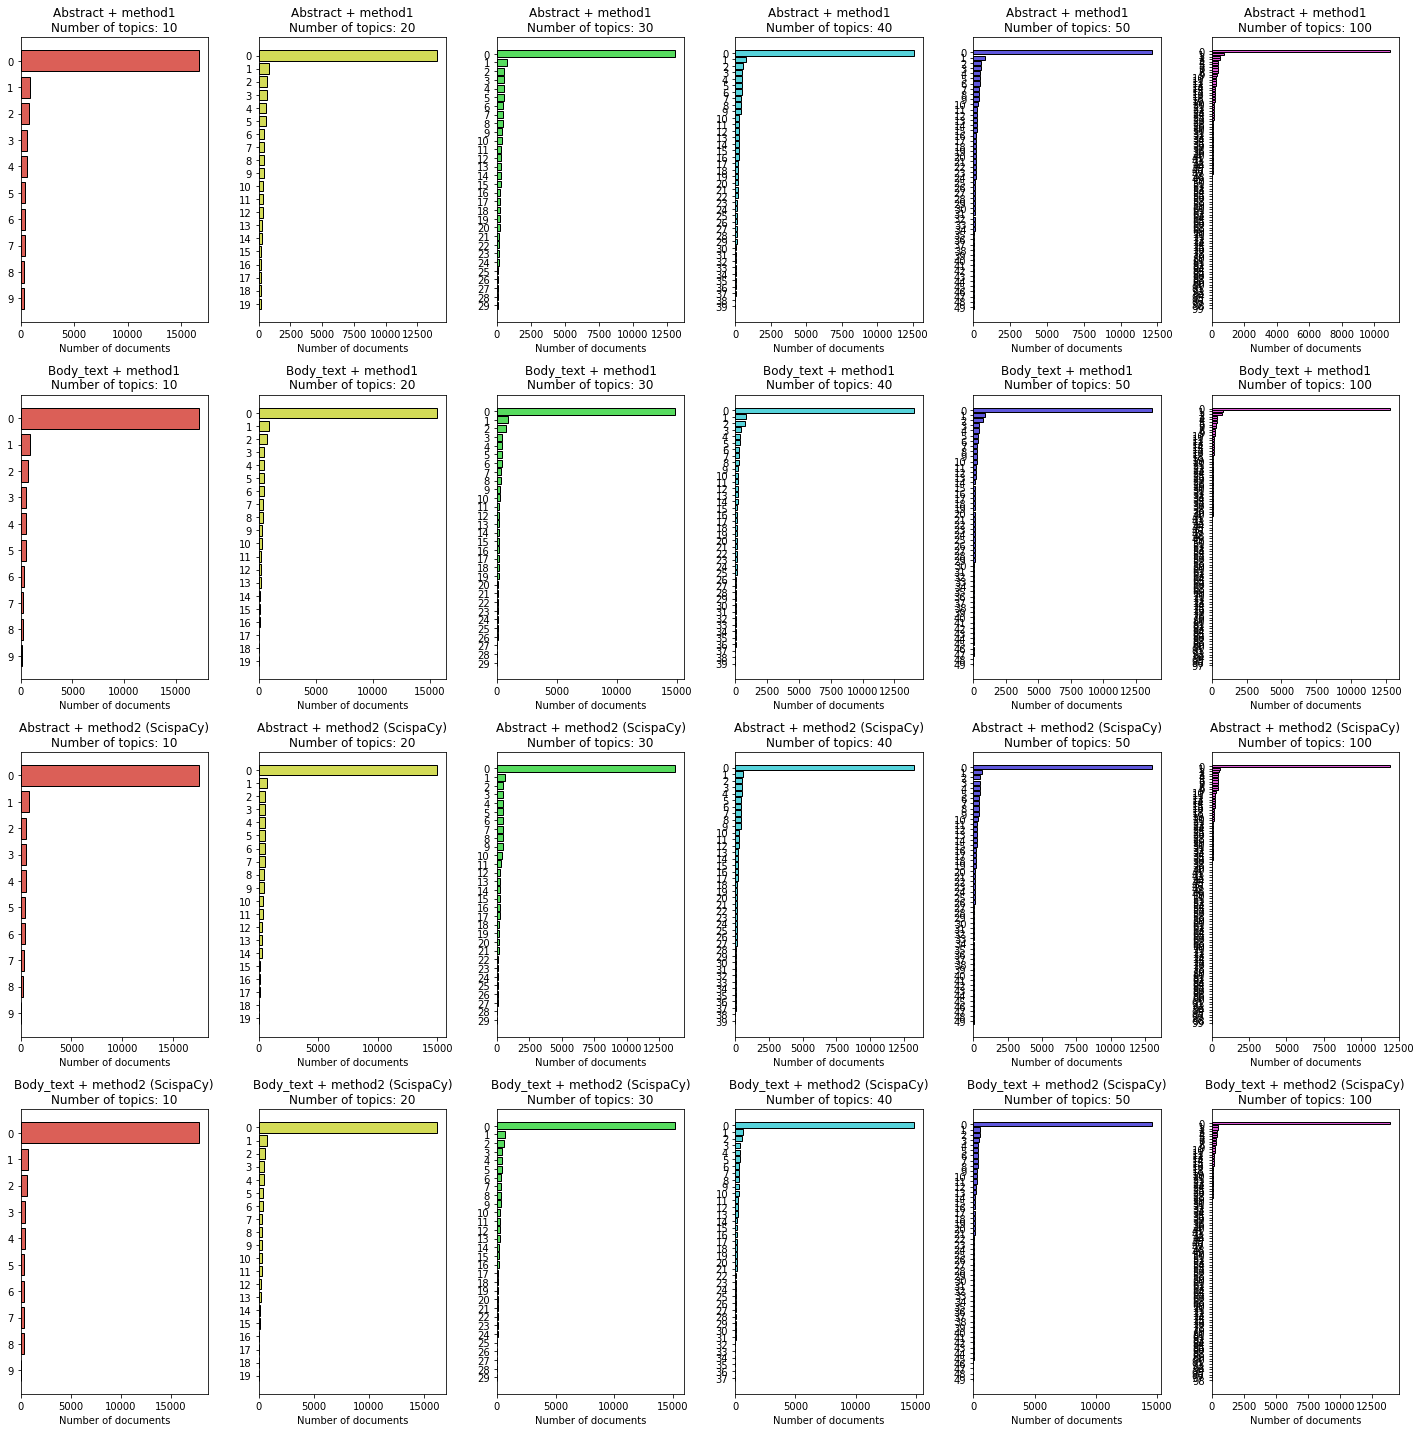

In [325]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file=files[i][j]
        axes[i][j].barh(np.arange(len(file)),file.counts,edgecolor="black",color=palette[j])
        axes[i][j].set_yticks(np.arange(len(file)))
        #axes[i][j].set_yticklabels(["Topic{}".format(i) for i in file.index])
        axes[i][j].invert_yaxis()
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
        axes[i][j].set_xlabel("Number of documents")
plt.tight_layout()

<a id='Part3.2_link'></a>
### 3.2 Evaluate the topic prediction performance of LSA models

In [326]:
pred1_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred1_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred1_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred2_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index_col="paper_id")
pred3_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index_col="paper_id")
pred4_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index_col="paper_id")
pred5_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index_col="paper_id")
pred6_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index_col="paper_id")
pred7_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index_col="paper_id")
pred8_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index_col="paper_id")
pred9_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index_col="paper_id")
pred10_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index_col="paper_id")
pred11_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index_col="paper_id")
pred12_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index_col="paper_id")
pred13_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred14_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index_col="paper_id")
pred15_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index_col="paper_id")
pred16_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index_col="paper_id")
pred17_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index_col="paper_id")
pred18_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index_col="paper_id")
pred19_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index_col="paper_id")
pred20_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index_col="paper_id")
pred21_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index_col="paper_id")
pred22_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index_col="paper_id")
pred23_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index_col="paper_id")
pred24_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index_col="paper_id")

pred25_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index_col="paper_id")
pred26_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index_col="paper_id")
pred27_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index_col="paper_id")
pred28_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index_col="paper_id")
pred29_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index_col="paper_id")
pred30_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index_col="paper_id")
pred31_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index_col="paper_id")
pred32_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index_col="paper_id")
pred33_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index_col="paper_id")
pred34_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index_col="paper_id")
pred35_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index_col="paper_id")
pred36_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index_col="paper_id")
pred37_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index_col="paper_id")
pred38_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index_col="paper_id")
pred39_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index_col="paper_id")
pred40_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index_col="paper_id")
pred41_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index_col="paper_id")
pred42_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index_col="paper_id")
pred43_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index_col="paper_id")
pred44_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index_col="paper_id")
pred45_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index_col="paper_id")
pred46_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index_col="paper_id")
pred47_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index_col="paper_id")
pred48_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index_col="paper_id")


In [327]:
files=[[pred1_df,pred3_df,pred5_df,pred7_df,pred9_df,pred11_df],
       [pred2_df,pred4_df,pred6_df,pred8_df,pred10_df,pred12_df],
       [pred13_df,pred15_df,pred17_df,pred19_df,pred21_df,pred23_df],
       [pred14_df,pred16_df,pred18_df,pred20_df,pred22_df,pred24_df],
       [pred25_df,pred27_df,pred29_df,pred31_df,pred33_df,pred35_df],
       [pred26_df,pred28_df,pred30_df,pred32_df,pred34_df,pred36_df],
       [pred37_df,pred39_df,pred41_df,pred43_df,pred45_df,pred47_df],
       [pred38_df,pred40_df,pred42_df,pred44_df,pred46_df,pred48_df]]
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract pred Title","Abstract pred Bodytext","Bodytext pred Title","Bodytext pred Abstract"]
norms=[10,20,30,40,50,100]
bws=[1/10,1/20,1/30,1/40,1/50,1/100]

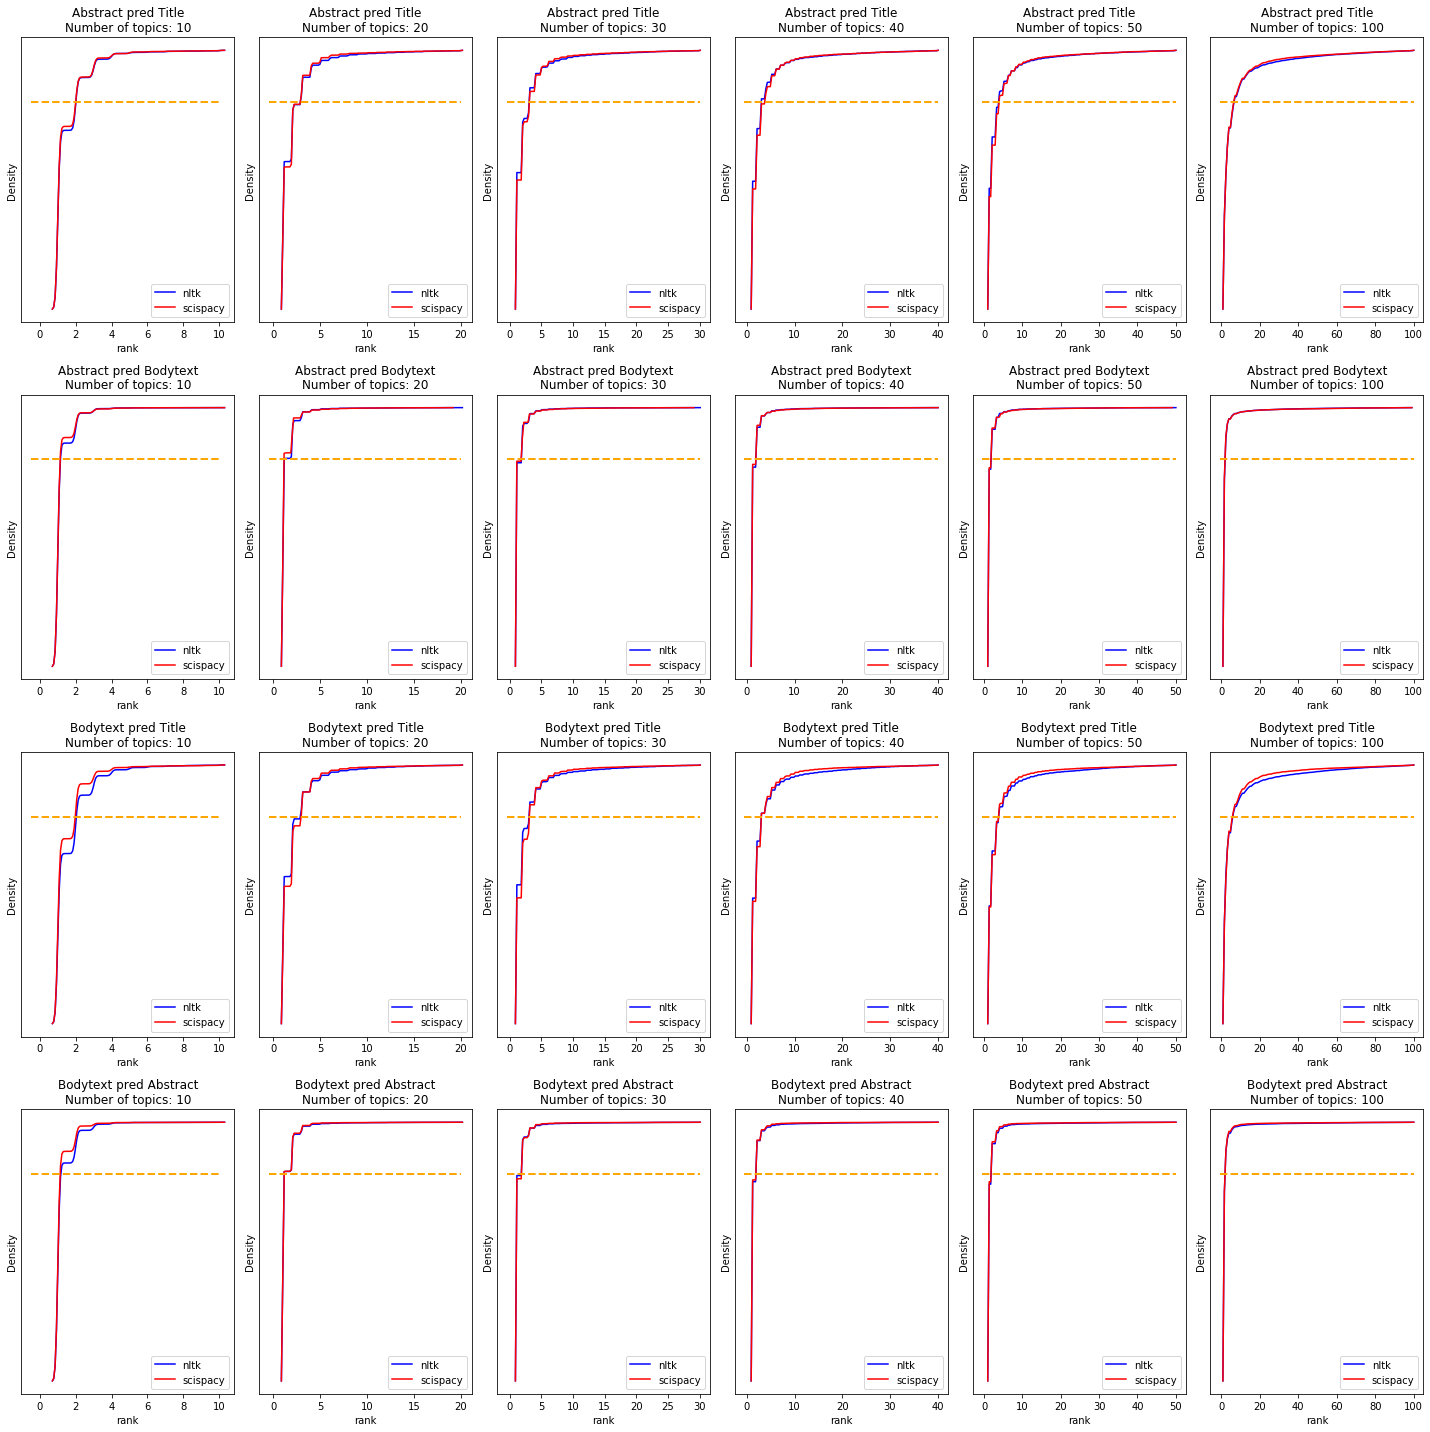

In [328]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.distplot(file1["rank"],ax=axes[i][j],hist=False,color="blue",label="nltk",hist_kws={"cumulative":True},kde_kws={"cumulative":True,"bw":bws[j]})
        sns.distplot(file2["rank"],ax=axes[i][j],hist=False,color="red",label="scispacy",hist_kws={"cumulative":True},kde_kws={"cumulative":True,"bw":bws[j]})
        axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

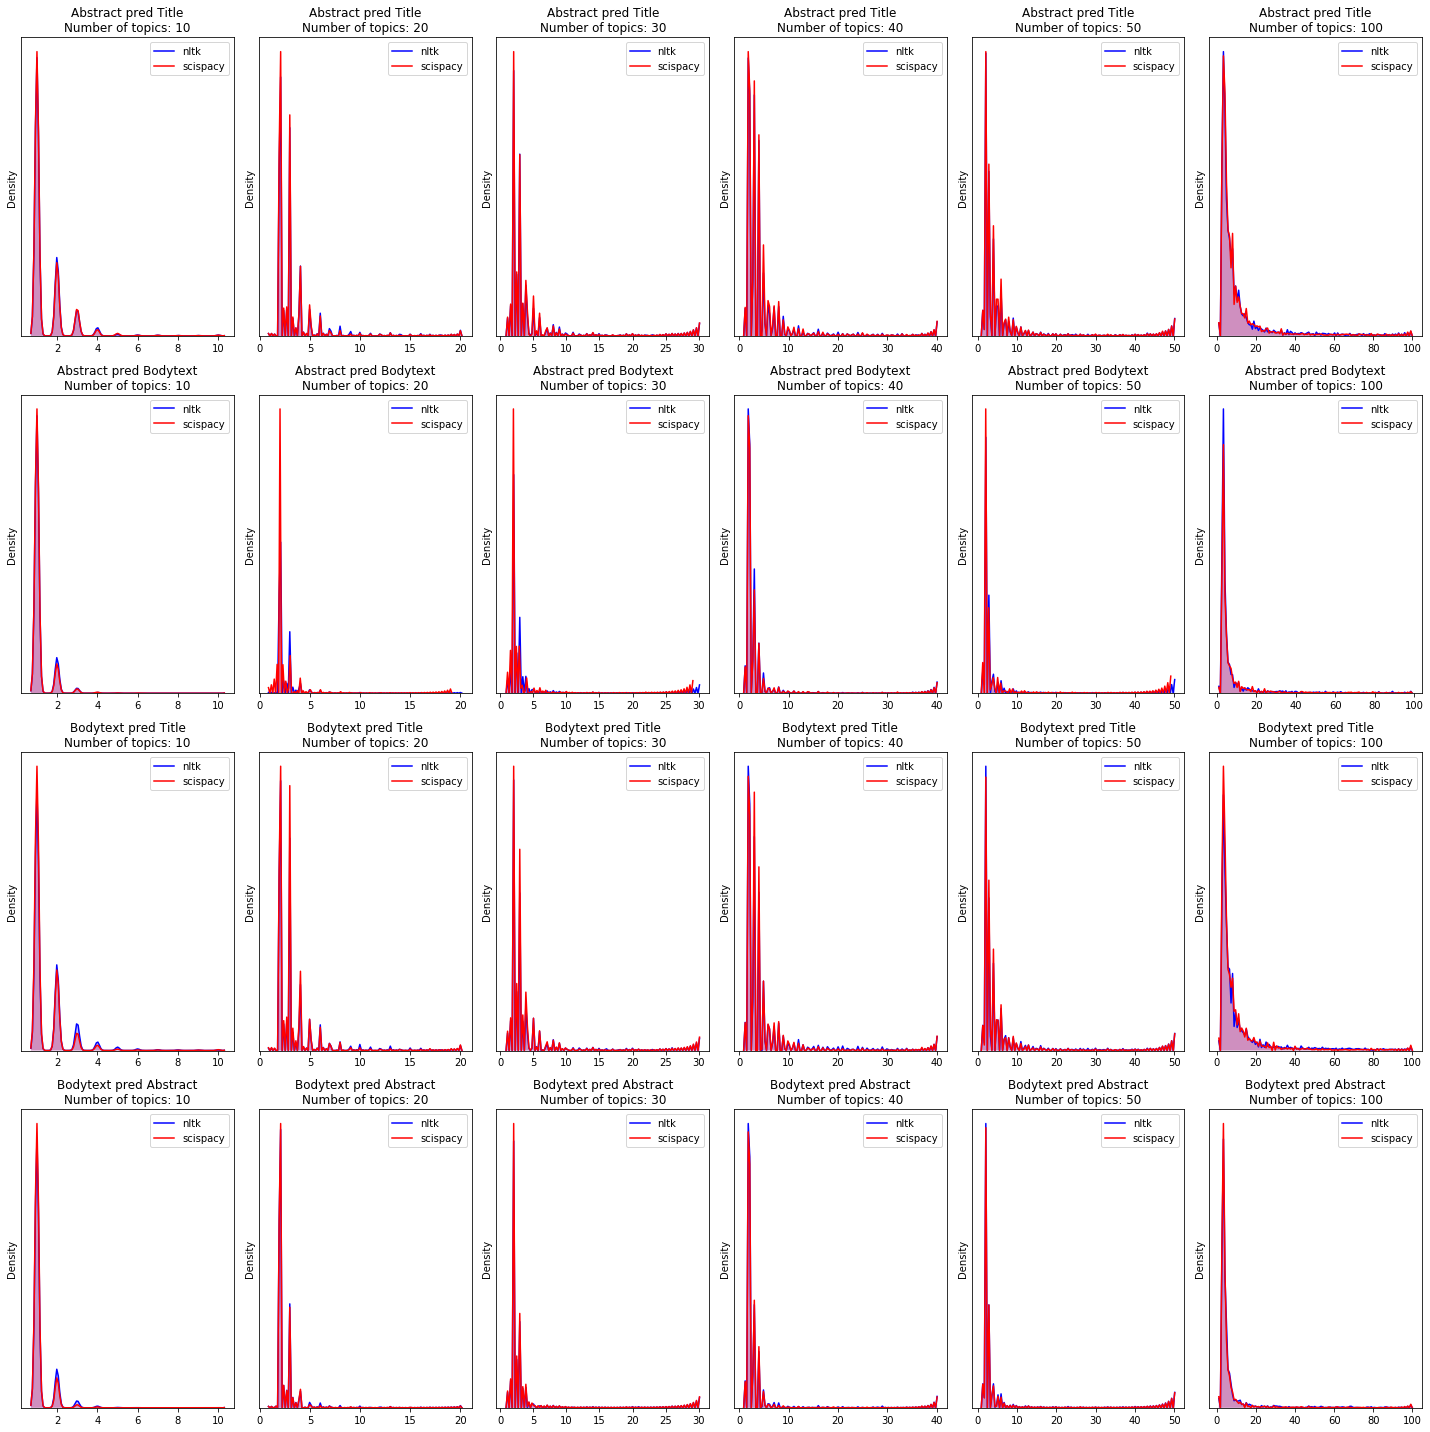

In [329]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.kdeplot(file1["rank"],ax=axes[i][j],shade=True,color="blue",label="nltk",bw=bws[j])
        sns.kdeplot(file2["rank"],ax=axes[i][j],shade=True,color="red",label="scispacy",bw=bws[j])
        #axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

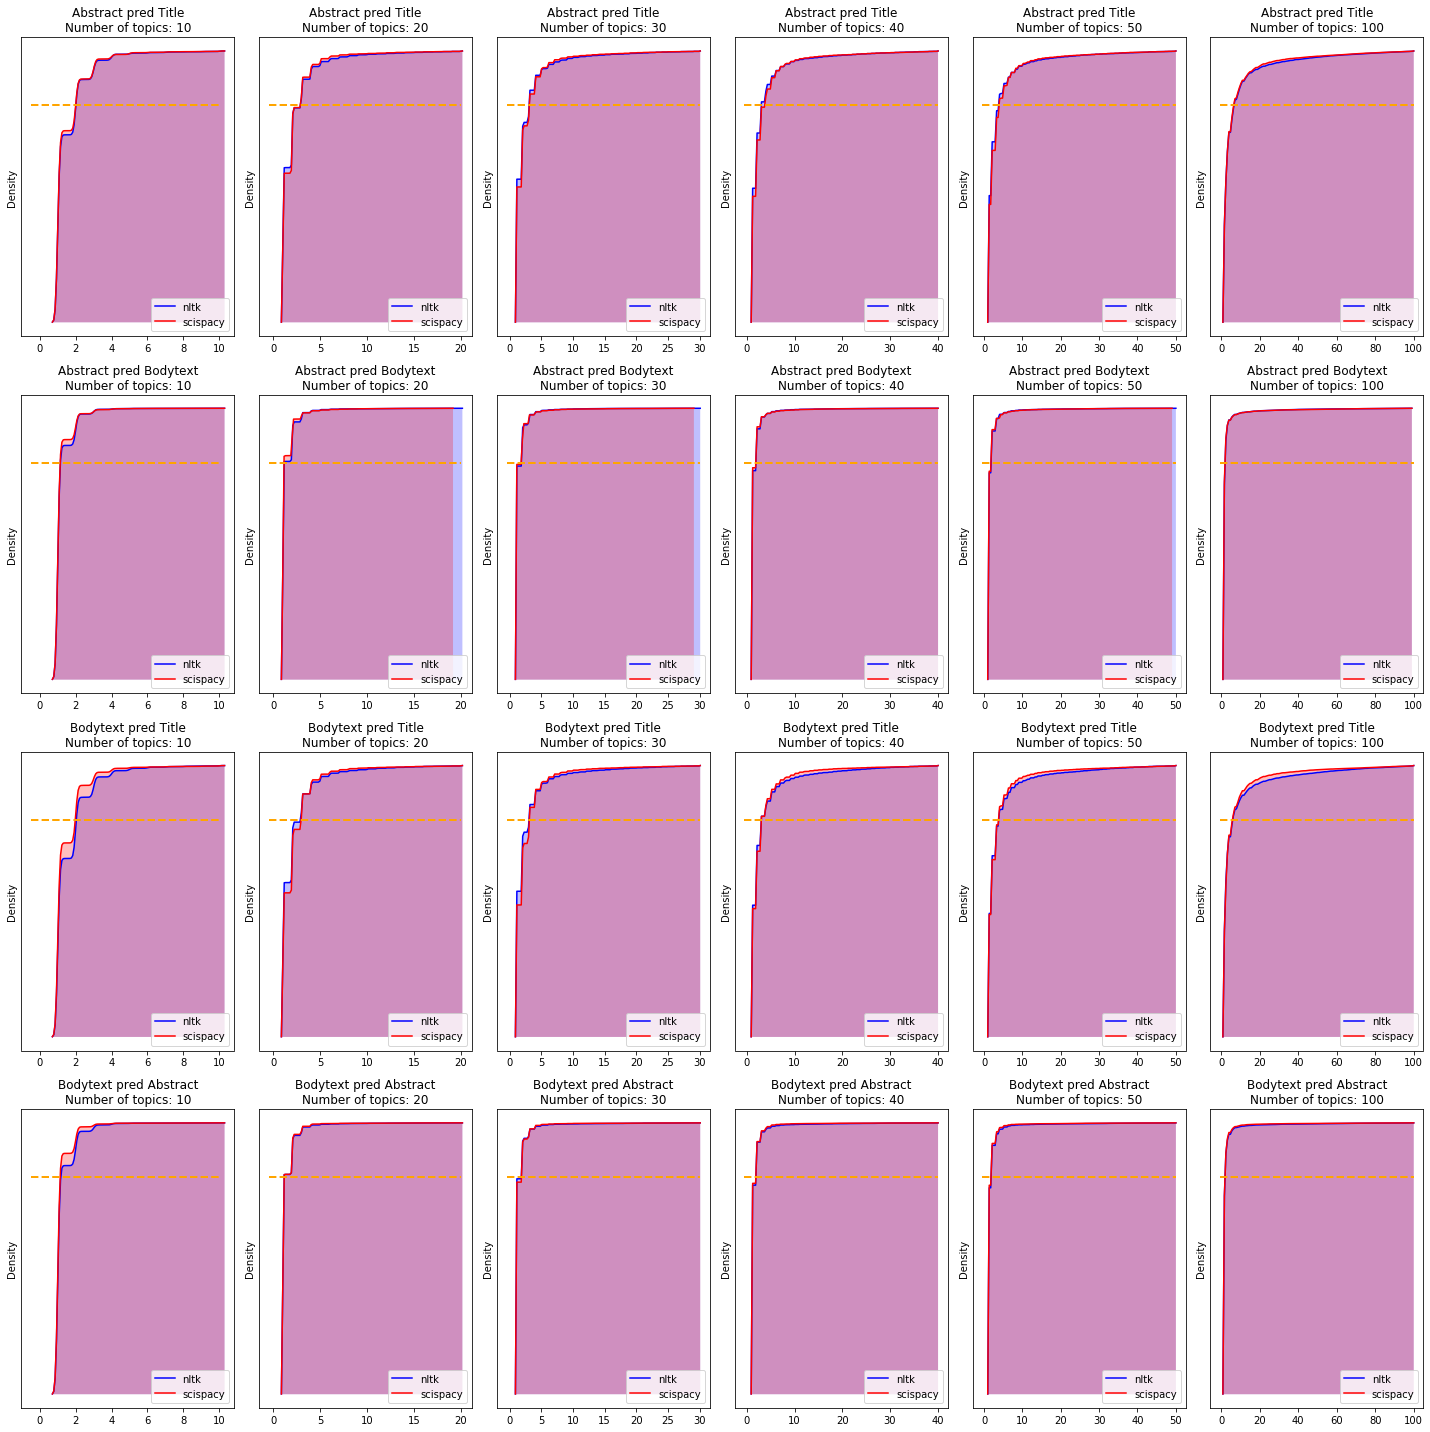

In [330]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.kdeplot(file1["rank"],ax=axes[i][j],shade=True,color="blue",label="nltk",bw=bws[j],cumulative=True)
        sns.kdeplot(file2["rank"],ax=axes[i][j],shade=True,color="red",label="scispacy",bw=bws[j],cumulative=True)
        axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

<a id='Part3.3_link'></a>
### 3.3 Compute cosine similarity for titles, abstracts and bodytext of each paper

In [ ]:
lsavector1_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector10_df.csv"),index_col="paper_id")
lsavector2_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector20_df.csv"),index_col="paper_id")
lsavector3_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector30_df.csv"),index_col="paper_id")
lsavector4_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector40_df.csv"),index_col="paper_id")
lsavector5_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector50_df.csv"),index_col="paper_id")
lsavector6_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector100_df.csv"),index_col="paper_id")
lsavector7_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector10_df.csv"),index_col="paper_id")
lsavector8_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector20_df.csv"),index_col="paper_id")
lsavector9_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector30_df.csv"),index_col="paper_id")
lsavector10_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector40_df.csv"),index_col="paper_id")
lsavector11_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector50_df.csv"),index_col="paper_id")
lsavector12_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector100_df.csv"),index_col="paper_id")
lsavector13_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector10_df.csv"),index_col="paper_id")
lsavector14_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector20_df.csv"),index_col="paper_id")
lsavector15_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector30_df.csv"),index_col="paper_id")
lsavector16_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector40_df.csv"),index_col="paper_id")
lsavector17_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector50_df.csv"),index_col="paper_id")
lsavector18_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector100_df.csv"),index_col="paper_id")
lsavector19_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector10_df.csv"),index_col="paper_id")
lsavector20_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector20_df.csv"),index_col="paper_id")
lsavector21_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector30_df.csv"),index_col="paper_id")
lsavector22_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector40_df.csv"),index_col="paper_id")
lsavector23_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector50_df.csv"),index_col="paper_id")
lsavector24_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector100_df.csv"),index_col="paper_id")


In [3]:
pred1_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred2_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index_col="paper_id")
pred3_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index_col="paper_id")
pred4_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index_col="paper_id")
pred5_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index_col="paper_id")
pred6_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index_col="paper_id")
pred7_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index_col="paper_id")
pred8_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index_col="paper_id")
pred9_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index_col="paper_id")
pred10_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index_col="paper_id")
pred11_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index_col="paper_id")
pred12_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index_col="paper_id")
pred13_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred14_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index_col="paper_id")
pred15_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index_col="paper_id")
pred16_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index_col="paper_id")
pred17_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index_col="paper_id")
pred18_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index_col="paper_id")
pred19_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index_col="paper_id")
pred20_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index_col="paper_id")
pred21_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index_col="paper_id")
pred22_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index_col="paper_id")
pred23_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index_col="paper_id")
pred24_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index_col="paper_id")

pred25_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index_col="paper_id")
pred26_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index_col="paper_id")
pred27_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index_col="paper_id")
pred28_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index_col="paper_id")
pred29_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index_col="paper_id")
pred30_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index_col="paper_id")
pred31_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index_col="paper_id")
pred32_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index_col="paper_id")
pred33_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index_col="paper_id")
pred34_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index_col="paper_id")
pred35_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index_col="paper_id")
pred36_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index_col="paper_id")
pred37_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index_col="paper_id")
pred38_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index_col="paper_id")
pred39_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index_col="paper_id")
pred40_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index_col="paper_id")
pred41_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index_col="paper_id")
pred42_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index_col="paper_id")
pred43_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index_col="paper_id")
pred44_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index_col="paper_id")
pred45_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index_col="paper_id")
pred46_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index_col="paper_id")
pred47_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index_col="paper_id")
pred48_sk_df=pd.read_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index_col="paper_id")


In [ ]:
def get_similarity_rank(ldavector_df,query,paper_id):
    if np.isnan(query.squeeze()[0]):
        return len(ldavector_df)
    cos_sim=cosine_similarity(X=ldavector_df,Y=query)
    cos_sim_df=pd.DataFrame({"paper_id":ldavector_df.index,"cosine_similarity":cos_sim.squeeze()}).sort_values(by=["cosine_similarity"],ascending=False).reset_index().drop(["index"],axis=1)
    return int(cos_sim_df[cos_sim_df.paper_id==paper_id].index.values)

In [ ]:
pred1_sk_df["paper_id"]=pred1_sk_df.index
pred1_sk_df["cosine_similarity_rank"]=pred1_sk_df.apply(lambda x:get_similarity_rank(lsavector1_sk_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred1_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index=False)

In [ ]:
pred2_sk_df["paper_id"]=pred2_sk_df.index
pred2_sk_df["cosine_similarity_rank"]=pred2_sk_df.apply(lambda x:get_similarity_rank(lsavector1_sk_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred2_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index=False)

In [ ]:
pred3_sk_df["paper_id"]=pred3_sk_df.index
pred3_sk_df["cosine_similarity_rank"]=pred3_sk_df.apply(lambda x:get_similarity_rank(lsavector2_sk_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred3_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index=False)


In [ ]:
pred4_sk_df["paper_id"]=pred4_sk_df.index
pred4_sk_df["cosine_similarity_rank"]=pred4_sk_df.apply(lambda x:get_similarity_rank(lsavector2_sk_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred4_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index=False)


In [ ]:
pred5_sk_df["paper_id"]=pred5_sk_df.index
pred5_sk_df["cosine_similarity_rank"]=pred5_sk_df.apply(lambda x:get_similarity_rank(lsavector3_sk_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred5_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index=False)


In [ ]:
pred6_sk_df["paper_id"]=pred6_sk_df.index
pred6_sk_df["cosine_similarity_rank"]=pred6_sk_df.apply(lambda x:get_similarity_rank(lsavector3_sk_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred6_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index=False)


In [ ]:
pred7_sk_df["paper_id"]=pred7_sk_df.index
pred7_sk_df["cosine_similarity_rank"]=pred7_sk_df.apply(lambda x:get_similarity_rank(lsavector4_sk_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred7_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index=False)


In [ ]:
pred8_sk_df["paper_id"]=pred8_sk_df.index
pred8_sk_df["cosine_similarity_rank"]=pred8_sk_df.apply(lambda x:get_similarity_rank(lsavector4_sk_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred8_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index=False)


In [ ]:
pred9_sk_df["paper_id"]=pred9_sk_df.index
pred9_sk_df["cosine_similarity_rank"]=pred9_sk_df.apply(lambda x:get_similarity_rank(lsavector5_sk_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred9_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index=False)


In [ ]:
pred10_sk_df["paper_id"]=pred10_sk_df.index
pred10_sk_df["cosine_similarity_rank"]=pred10_sk_df.apply(lambda x:get_similarity_rank(lsavector5_sk_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred10_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index=False)


In [ ]:
pred11_sk_df["paper_id"]=pred11_sk_df.index
pred11_sk_df["cosine_similarity_rank"]=pred11_sk_df.apply(lambda x:get_similarity_rank(lsavector6_sk_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred11_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index=False)


In [ ]:
pred12_sk_df["paper_id"]=pred12_sk_df.index
pred12_sk_df["cosine_similarity_rank"]=pred12_sk_df.apply(lambda x:get_similarity_rank(lsavector6_sk_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred12_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index=False)


In [ ]:
pred13_sk_df["paper_id"]=pred13_sk_df.index
pred13_sk_df["cosine_similarity_rank"]=pred13_sk_df.apply(lambda x:get_similarity_rank(lsavector7_sk_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred13_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index=False)


In [ ]:
pred14_sk_df["paper_id"]=pred14_sk_df.index
pred14_sk_df["cosine_similarity_rank"]=pred14_sk_df.apply(lambda x:get_similarity_rank(lsavector7_sk_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred14_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index=False)


In [ ]:
pred15_sk_df["paper_id"]=pred15_sk_df.index
pred15_sk_df["cosine_similarity_rank"]=pred15_sk_df.apply(lambda x:get_similarity_rank(lsavector8_sk_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred15_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index=False)


In [ ]:
pred16_sk_df["paper_id"]=pred16_sk_df.index
pred16_sk_df["cosine_similarity_rank"]=pred16_sk_df.apply(lambda x:get_similarity_rank(lsavector8_sk_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred16_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index=False)


In [ ]:
pred17_sk_df["paper_id"]=pred17_sk_df.index
pred17_sk_df["cosine_similarity_rank"]=pred17_sk_df.apply(lambda x:get_similarity_rank(lsavector9_sk_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred17_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index=False)


In [ ]:
pred18_sk_df["paper_id"]=pred18_sk_df.index
pred18_sk_df["cosine_similarity_rank"]=pred18_sk_df.apply(lambda x:get_similarity_rank(lsavector9_sk_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred18_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index=False)


In [ ]:
pred19_sk_df["paper_id"]=pred19_sk_df.index
pred19_sk_df["cosine_similarity_rank"]=pred19_sk_df.apply(lambda x:get_similarity_rank(lsavector10_sk_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred19_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index=False)


In [ ]:
pred20_sk_df["paper_id"]=pred20_sk_df.index
pred20_sk_df["cosine_similarity_rank"]=pred20_sk_df.apply(lambda x:get_similarity_rank(lsavector10_sk_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred20_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index=False)


In [ ]:
pred21_sk_df["paper_id"]=pred21_sk_df.index
pred21_sk_df["cosine_similarity_rank"]=pred21_sk_df.apply(lambda x:get_similarity_rank(lsavector11_sk_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred21_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index=False)


In [ ]:
pred22_sk_df["paper_id"]=pred22_sk_df.index
pred22_sk_df["cosine_similarity_rank"]=pred22_sk_df.apply(lambda x:get_similarity_rank(lsavector11_sk_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred22_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index=False)


In [ ]:
pred23_sk_df["paper_id"]=pred23_sk_df.index
pred23_sk_df["cosine_similarity_rank"]=pred23_sk_df.apply(lambda x:get_similarity_rank(lsavector12_sk_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred23_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index=False)


In [ ]:
pred24_sk_df["paper_id"]=pred24_sk_df.index
pred24_sk_df["cosine_similarity_rank"]=pred24_sk_df.apply(lambda x:get_similarity_rank(lsavector12_sk_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred24_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index=False)


In [ ]:
pred25_sk_df["paper_id"]=pred25_sk_df.index
pred25_sk_df["cosine_similarity_rank"]=pred25_sk_df.apply(lambda x:get_similarity_rank(lsavector13_sk_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred25_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index=False)


In [ ]:
pred26_sk_df["paper_id"]=pred26_sk_df.index
pred26_sk_df["cosine_similarity_rank"]=pred26_sk_df.apply(lambda x:get_similarity_rank(lsavector13_sk_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred26_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index=False)


In [ ]:
pred27_sk_df["paper_id"]=pred27_sk_df.index
pred27_sk_df["cosine_similarity_rank"]=pred27_sk_df.apply(lambda x:get_similarity_rank(lsavector14_sk_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred27_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index=False)


In [ ]:
pred28_sk_df["paper_id"]=pred28_sk_df.index
pred28_sk_df["cosine_similarity_rank"]=pred28_sk_df.apply(lambda x:get_similarity_rank(lsavector14_sk_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred28_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index=False)


In [ ]:
pred29_sk_df["paper_id"]=pred29_sk_df.index
pred29_sk_df["cosine_similarity_rank"]=pred29_sk_df.apply(lambda x:get_similarity_rank(lsavector15_sk_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred29_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index=False)


In [ ]:
pred30_sk_df["paper_id"]=pred30_sk_df.index
pred30_sk_df["cosine_similarity_rank"]=pred30_sk_df.apply(lambda x:get_similarity_rank(lsavector15_sk_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred30_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index=False)


In [ ]:
pred31_sk_df["paper_id"]=pred31_sk_df.index
pred31_sk_df["cosine_similarity_rank"]=pred31_sk_df.apply(lambda x:get_similarity_rank(lsavector16_sk_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred31_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index=False)


In [ ]:
pred32_sk_df["paper_id"]=pred32_sk_df.index
pred32_sk_df["cosine_similarity_rank"]=pred32_sk_df.apply(lambda x:get_similarity_rank(lsavector16_sk_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred32_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index=False)


In [ ]:
pred33_sk_df["paper_id"]=pred33_sk_df.index
pred33_sk_df["cosine_similarity_rank"]=pred33_sk_df.apply(lambda x:get_similarity_rank(lsavector17_sk_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred33_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index=False)


In [ ]:
pred34_sk_df["paper_id"]=pred34_sk_df.index
pred34_sk_df["cosine_similarity_rank"]=pred34_sk_df.apply(lambda x:get_similarity_rank(lsavector17_sk_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred34_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index=False)


In [ ]:
pred35_sk_df["paper_id"]=pred35_sk_df.index
pred35_sk_df["cosine_similarity_rank"]=pred35_sk_df.apply(lambda x:get_similarity_rank(lsavector18_sk_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred35_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index=False)


In [ ]:
pred36_sk_df["paper_id"]=pred36_sk_df.index
pred36_sk_df["cosine_similarity_rank"]=pred36_sk_df.apply(lambda x:get_similarity_rank(lsavector18_sk_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred36_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index=False)


In [ ]:
pred37_sk_df["paper_id"]=pred37_sk_df.index
pred37_sk_df["cosine_similarity_rank"]=pred37_sk_df.apply(lambda x:get_similarity_rank(lsavector19_sk_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred37_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index=False)


In [ ]:
pred38_sk_df["paper_id"]=pred38_sk_df.index
pred38_sk_df["cosine_similarity_rank"]=pred38_sk_df.apply(lambda x:get_similarity_rank(lsavector19_sk_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred38_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index=False)


In [ ]:
pred39_sk_df["paper_id"]=pred39_sk_df.index
pred39_sk_df["cosine_similarity_rank"]=pred39_sk_df.apply(lambda x:get_similarity_rank(lsavector20_sk_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred39_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index=False)


In [ ]:
pred40_sk_df["paper_id"]=pred40_sk_df.index
pred40_sk_df["cosine_similarity_rank"]=pred40_sk_df.apply(lambda x:get_similarity_rank(lsavector20_sk_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred40_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index=False)


In [ ]:
pred41_sk_df["paper_id"]=pred41_sk_df.index
pred41_sk_df["cosine_similarity_rank"]=pred41_sk_df.apply(lambda x:get_similarity_rank(lsavector21_sk_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred41_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index=False)


In [ ]:
pred42_sk_df["paper_id"]=pred42_sk_df.index
pred42_sk_df["cosine_similarity_rank"]=pred42_sk_df.apply(lambda x:get_similarity_rank(lsavector21_sk_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred42_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index=False)


In [ ]:
pred43_sk_df["paper_id"]=pred43_sk_df.index
pred43_sk_df["cosine_similarity_rank"]=pred43_sk_df.apply(lambda x:get_similarity_rank(lsavector22_sk_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred43_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index=False)


In [ ]:
pred44_sk_df["paper_id"]=pred44_sk_df.index
pred44_sk_df["cosine_similarity_rank"]=pred44_sk_df.apply(lambda x:get_similarity_rank(lsavector22_sk_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred44_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index=False)


In [ ]:
pred45_sk_df["paper_id"]=pred45_sk_df.index
pred45_sk_df["cosine_similarity_rank"]=pred45_sk_df.apply(lambda x:get_similarity_rank(lsavector23_sk_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred45_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index=False)


In [ ]:
pred46_sk_df["paper_id"]=pred46_sk_df.index
pred46_sk_df["cosine_similarity_rank"]=pred46_sk_df.apply(lambda x:get_similarity_rank(lsavector23_sk_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred46_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index=False)


In [ ]:
pred47_sk_df["paper_id"]=pred47_sk_df.index
pred47_sk_df["cosine_similarity_rank"]=pred47_sk_df.apply(lambda x:get_similarity_rank(lsavector24_sk_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred47_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index=False)


In [ ]:
pred48_sk_df["paper_id"]=pred48_sk_df.index
pred48_sk_df["cosine_similarity_rank"]=pred48_sk_df.apply(lambda x:get_similarity_rank(lsavector24_sk_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred48_sk_df.to_csv(os.path.join(base_dir,"models_lsa_sklearn_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index=False)


<a id='Part3.4_link'></a>
### 3.4 Evaluate cosine similarity

In [14]:
pred_files_sklearn=[pred1_sk_df,pred3_sk_df,pred5_sk_df,pred7_sk_df,pred9_sk_df,pred11_sk_df,
                    pred2_sk_df,pred4_sk_df,pred6_sk_df,pred8_sk_df,pred10_sk_df,pred12_sk_df,
                    pred13_sk_df,pred15_sk_df,pred17_sk_df,pred19_sk_df,pred21_sk_df,pred23_sk_df,
                    pred14_sk_df,pred16_sk_df,pred18_sk_df,pred20_sk_df,pred22_sk_df,pred24_sk_df,
                    pred25_sk_df,pred27_sk_df,pred29_sk_df,pred31_sk_df,pred33_sk_df,pred35_sk_df,
                    pred26_sk_df,pred28_sk_df,pred30_sk_df,pred32_sk_df,pred34_sk_df,pred36_sk_df,
                    pred37_sk_df,pred39_sk_df,pred41_sk_df,pred43_sk_df,pred45_sk_df,pred47_sk_df,
                    pred38_sk_df,pred40_sk_df,pred42_sk_df,pred44_sk_df,pred46_sk_df,pred48_sk_df]

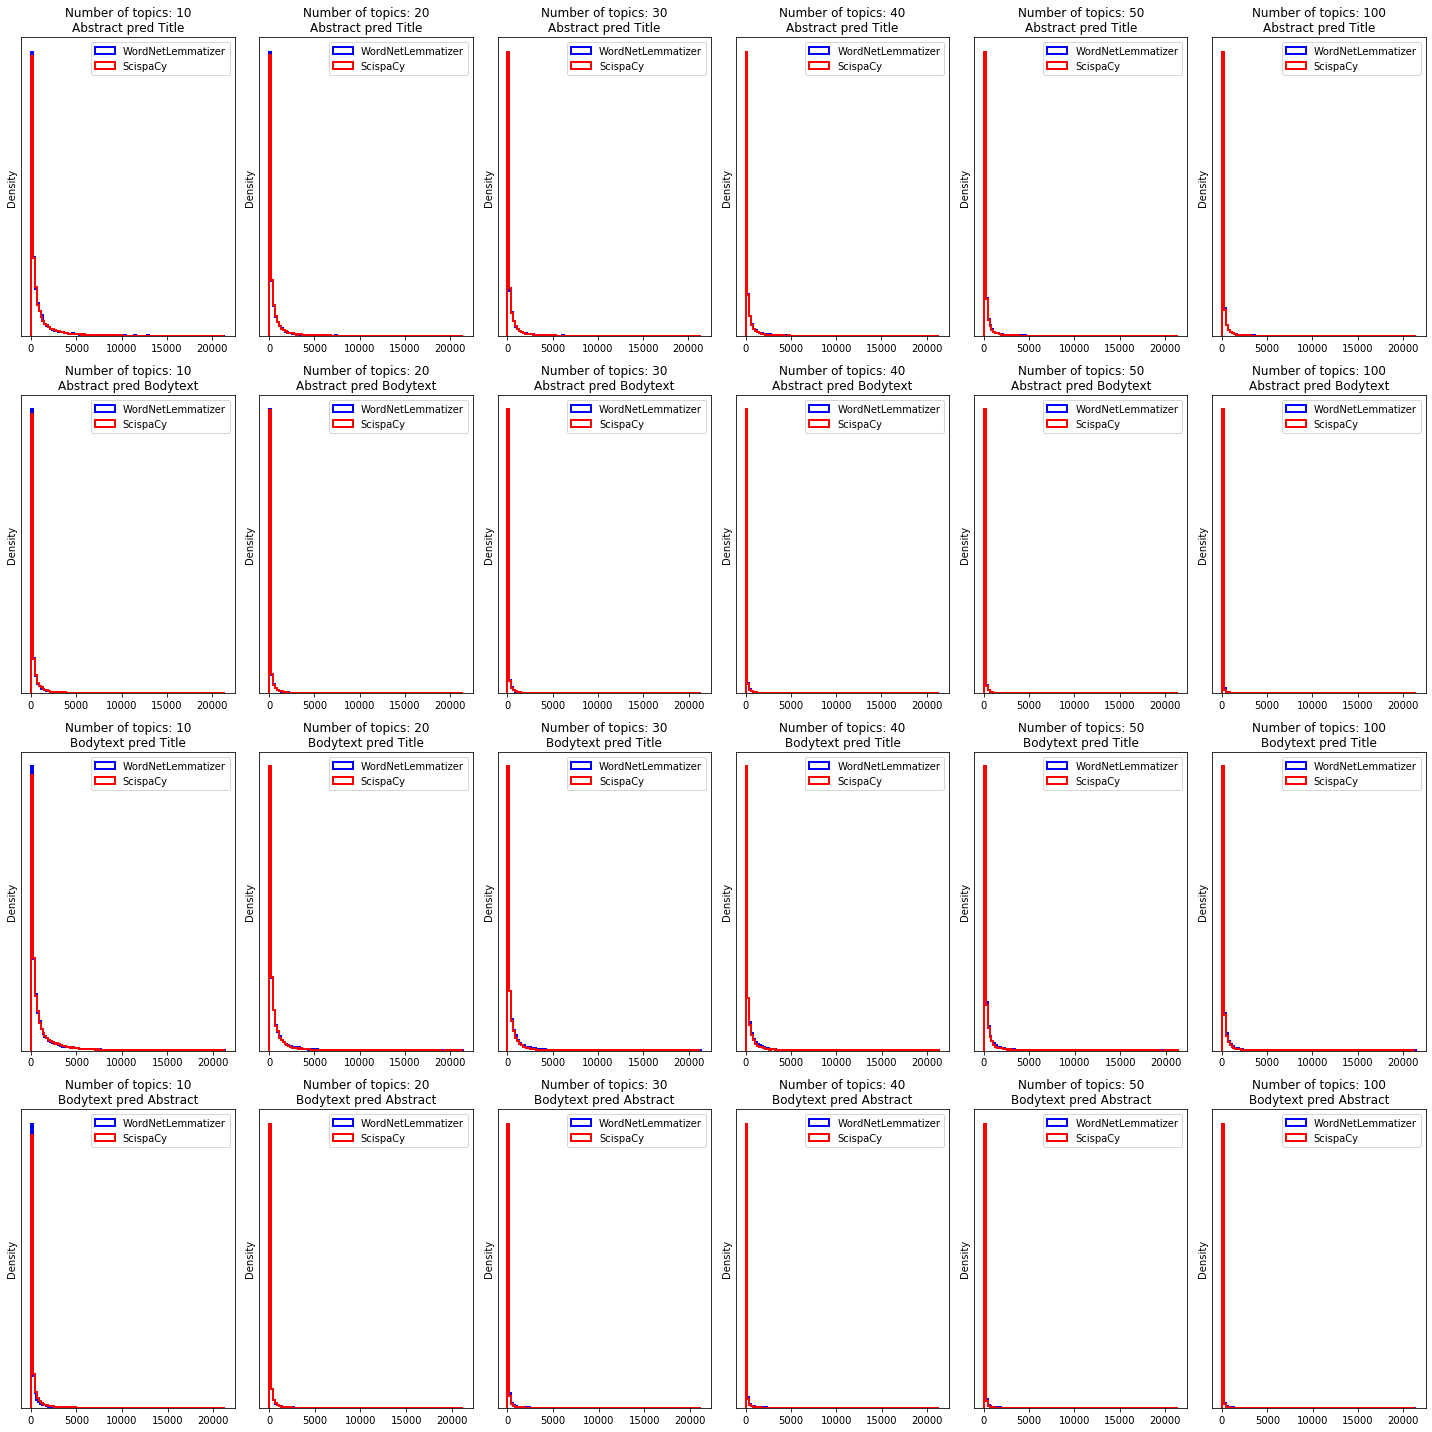

In [19]:
## compare WordNetLemmatizer and scispacy
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract pred Title","Abstract pred Bodytext","Bodytext pred Title","Bodytext pred Abstract"]

fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(24):
    file1=pred_files_sklearn[i]
    file2=pred_files_sklearn[i+24]
    axes[i//6][i%6].hist(file1["cosine_similarity_rank"],bins=100,histtype="step",color="blue",label="WordNetLemmatizer",linewidth=2)
    axes[i//6][i%6].hist(file2["cosine_similarity_rank"],bins=100,histtype="step",color="red",label="ScispaCy",linewidth=2)
    axes[i//6][i%6].set_yticks([])
    axes[i//6][i%6].set_ylabel("Density")
    axes[i//6][i%6].set_title(filename_list1[i%6]+"\n"+filename_list2[i//6])
    axes[i//6][i%6].legend()
plt.tight_layout()

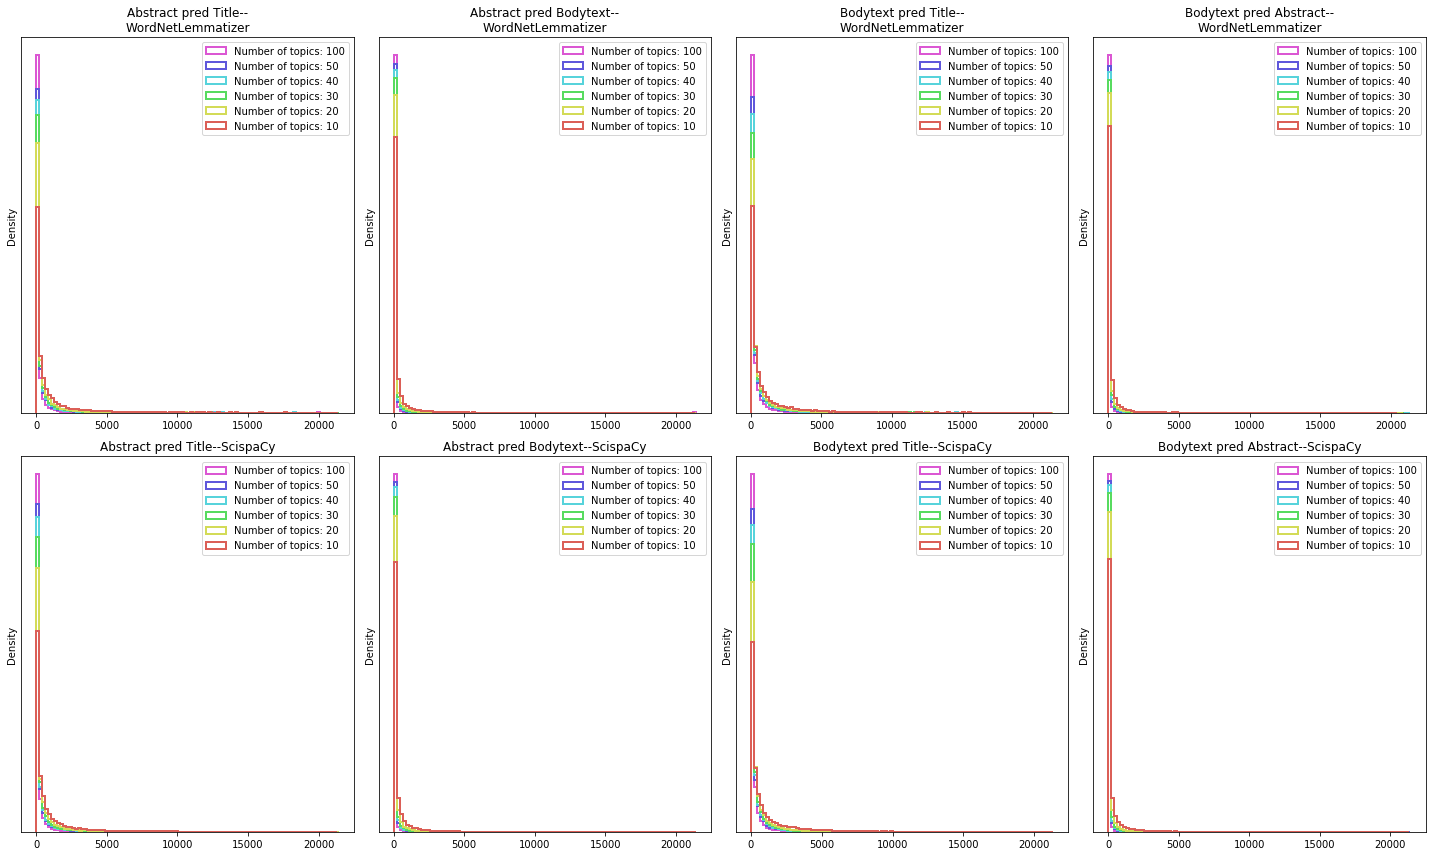

In [22]:
filename_list3=["Abstract pred Title--\nWordNetLemmatizer","Abstract pred Bodytext--\nWordNetLemmatizer","Bodytext pred Title--\nWordNetLemmatizer","Bodytext pred Abstract--\nWordNetLemmatizer",
                "Abstract pred Title--ScispaCy","Abstract pred Bodytext--ScispaCy","Bodytext pred Title--ScispaCy","Bodytext pred Abstract--ScispaCy"]
palette=sns.color_palette("hls",6)

fig,axes=plt.subplots(2,4,figsize=(20,12))
for i in range(7,-1,-1):
    for j in range(5,-1,-1):
        file=pred_files_sklearn[i*6+j]
        axes[i//4][i%4].hist(file["cosine_similarity_rank"],bins=100,histtype="step",color=palette[j],label=filename_list1[j],linewidth=2)
    axes[i//4][i%4].set_yticks([])
    axes[i//4][i%4].set_ylabel("Density")
    axes[i//4][i%4].set_title(filename_list3[i])
    axes[i//4][i%4].legend()
plt.tight_layout()

<a id='Part4_link'></a>
## 4. Compare LSA models using Gensim and Sklearn

In [8]:
pred1_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred2_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index_col="paper_id")
pred3_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index_col="paper_id")
pred4_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index_col="paper_id")
pred5_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index_col="paper_id")
pred6_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index_col="paper_id")
pred7_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index_col="paper_id")
pred8_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index_col="paper_id")
pred9_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index_col="paper_id")
pred10_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index_col="paper_id")
pred11_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index_col="paper_id")
pred12_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index_col="paper_id")
pred13_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred14_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index_col="paper_id")
pred15_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index_col="paper_id")
pred16_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index_col="paper_id")
pred17_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index_col="paper_id")
pred18_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index_col="paper_id")
pred19_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index_col="paper_id")
pred20_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index_col="paper_id")
pred21_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index_col="paper_id")
pred22_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index_col="paper_id")
pred23_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index_col="paper_id")
pred24_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index_col="paper_id")

pred25_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index_col="paper_id")
pred26_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index_col="paper_id")
pred27_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index_col="paper_id")
pred28_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index_col="paper_id")
pred29_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index_col="paper_id")
pred30_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index_col="paper_id")
pred31_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index_col="paper_id")
pred32_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index_col="paper_id")
pred33_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index_col="paper_id")
pred34_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index_col="paper_id")
pred35_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index_col="paper_id")
pred36_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index_col="paper_id")
pred37_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index_col="paper_id")
pred38_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index_col="paper_id")
pred39_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index_col="paper_id")
pred40_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index_col="paper_id")
pred41_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index_col="paper_id")
pred42_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index_col="paper_id")
pred43_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index_col="paper_id")
pred44_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index_col="paper_id")
pred45_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index_col="paper_id")
pred46_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index_col="paper_id")
pred47_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index_col="paper_id")
pred48_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index_col="paper_id")


In [17]:
pred_files_gensim=[pred1_df,pred3_df,pred5_df,pred7_df,pred9_df,pred11_df,pred2_df,pred4_df,pred6_df,pred8_df,pred10_df,pred12_df,
                   pred13_df,pred15_df,pred17_df,pred19_df,pred21_df,pred23_df,pred14_df,pred16_df,pred18_df,pred20_df,pred22_df,pred24_df,
                   pred25_df,pred27_df,pred29_df,pred31_df,pred33_df,pred35_df,pred26_df,pred28_df,pred30_df,pred32_df,pred34_df,pred36_df,
                   pred37_df,pred39_df,pred41_df,pred43_df,pred45_df,pred47_df,pred38_df,pred40_df,pred42_df,pred44_df,pred46_df,pred48_df]


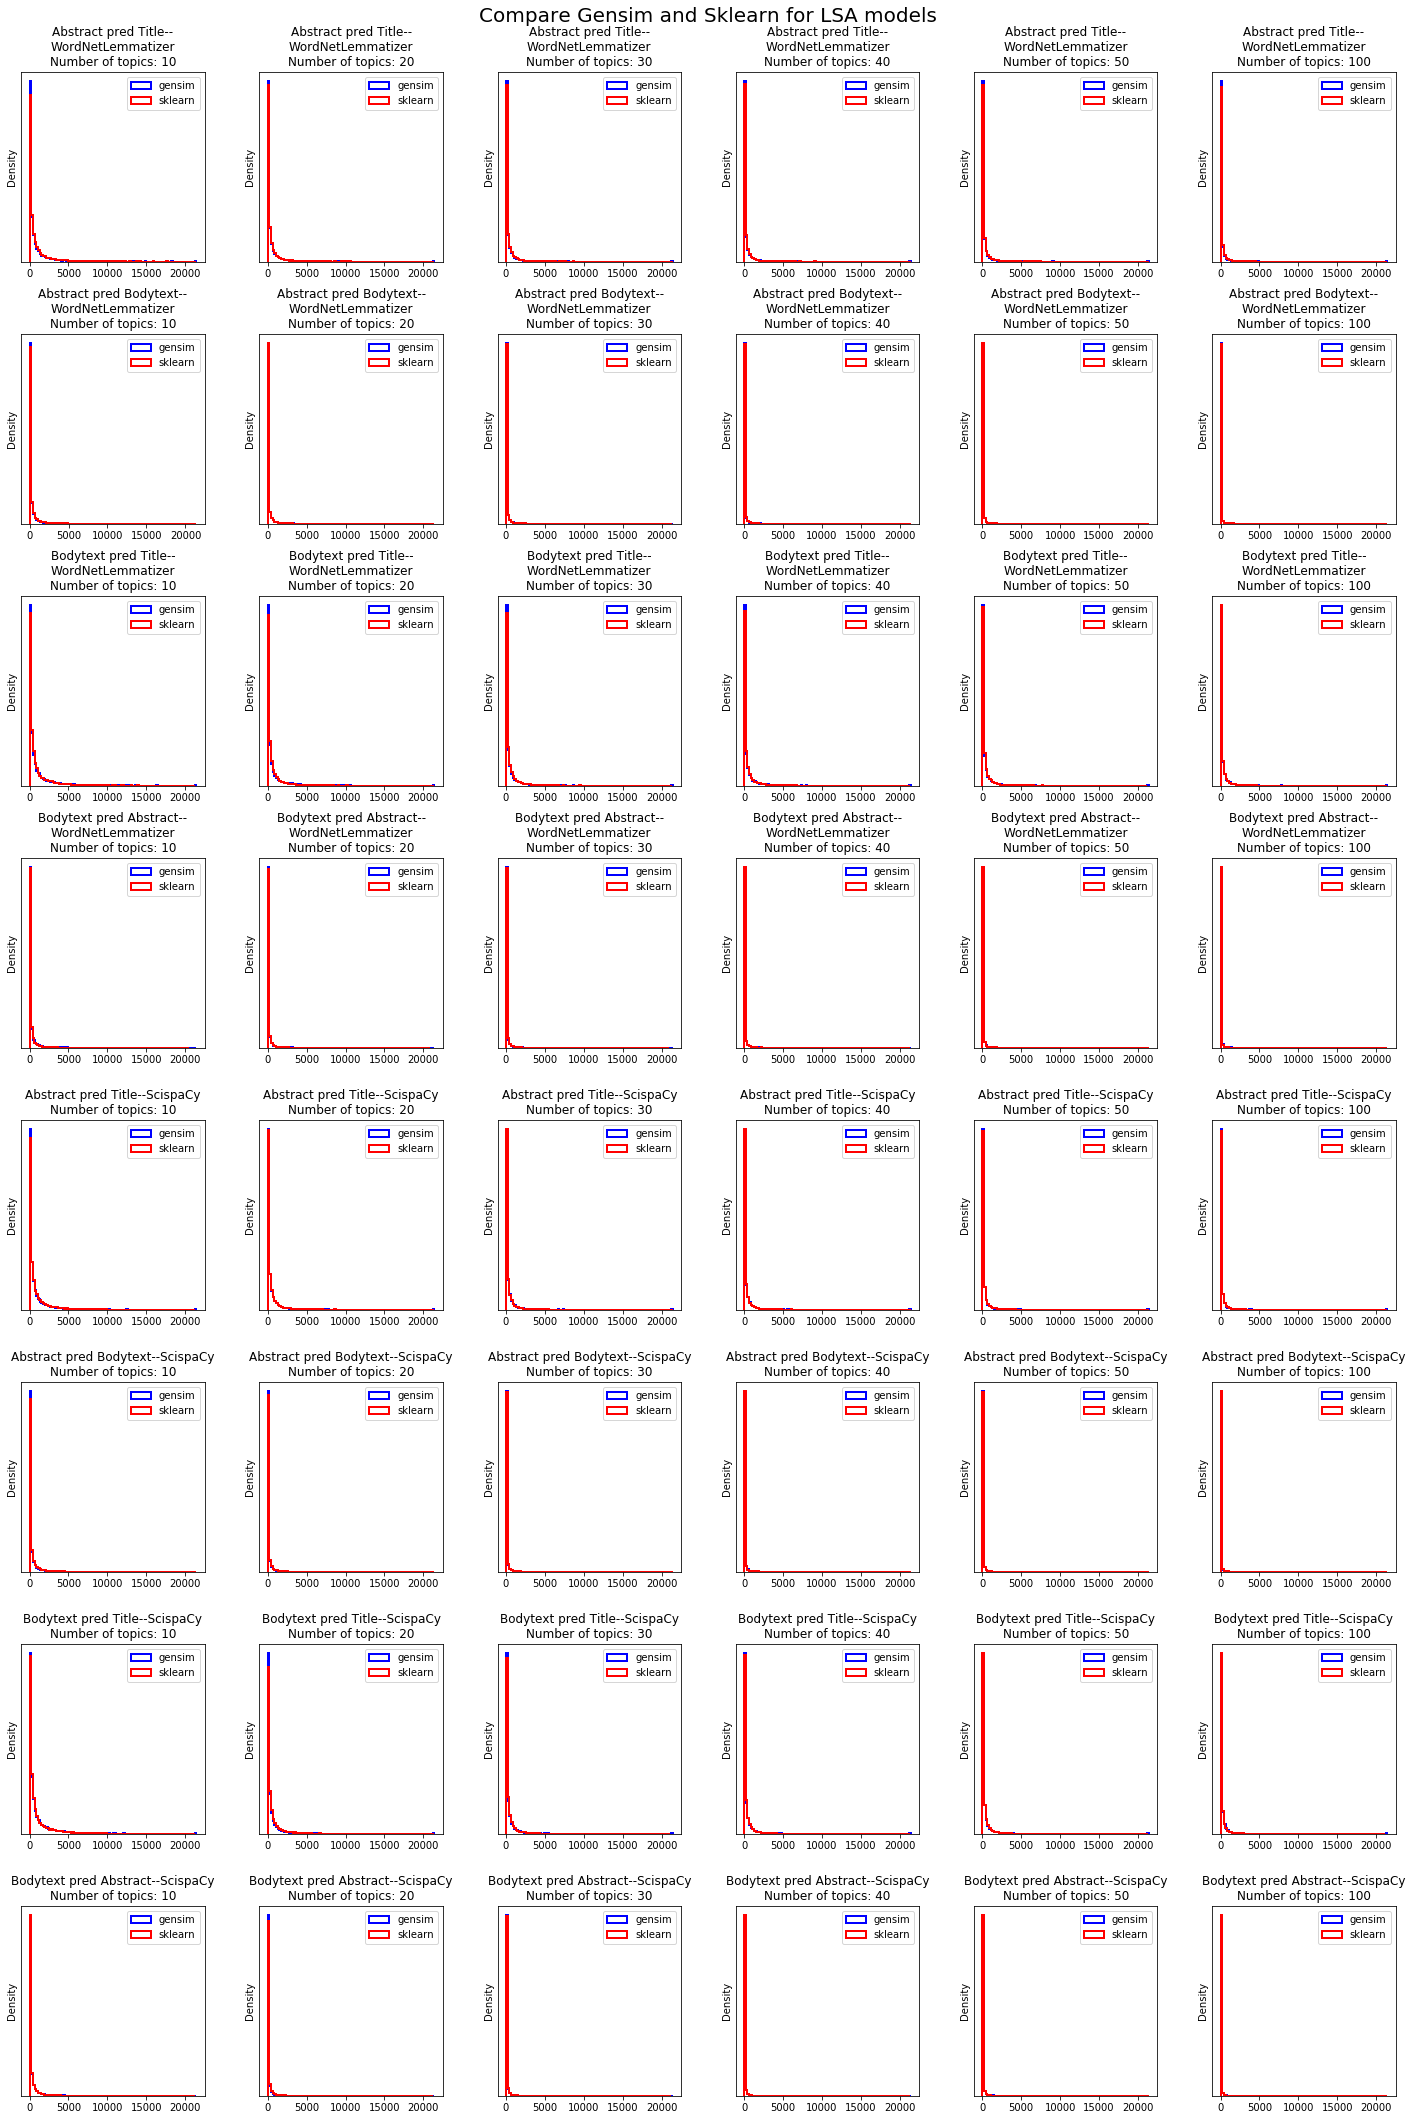

In [23]:
## Compare Gensim and Sklearn for LSA models
fig,axes=plt.subplots(8,6,figsize=(20,30))
for i in range(48):
    file1=pred_files_gensim[i]
    file2=pred_files_sklearn[i]
    axes[i//6][i%6].hist(file1["cosine_similarity_rank"],bins=100,histtype="step",color="blue",label="gensim",linewidth=2)
    axes[i//6][i%6].hist(file2["cosine_similarity_rank"],bins=100,histtype="step",color="red",label="sklearn",linewidth=2)
    axes[i//6][i%6].set_yticks([])
    axes[i//6][i%6].set_ylabel("Density")
    axes[i//6][i%6].set_title(filename_list3[i//6]+"\n"+filename_list1[i%6])
    axes[i//6][i%6].legend()
fig.suptitle("Compare Gensim and Sklearn for LSA models",fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

## Conclusion
<br> 1. **WordNetLemmatizer** and **ScispaCy** have comparable performance in preprocessing text
<br> 2. In general, increased number of topics in LSA analysis has better embedding performance based on the cosine similarity score rank among abstracts/titles/bodytext for each paper
<br> 3. There is comparable embedding performance between LSA models built using Gensim and Sklearn